# OCRA Demo
This notebook shows how to train or test the model. Also included are methods to display model outputs and attention mechanimsms 

In [1]:
# load required libraries & modules
import os
from tqdm.notebook import tqdm
import pprint
import time

import torch

from utils import *
from ocra import *
from loaddata import *

import warnings
# warnings.filterwarnings('ignore')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Instantiate Model for Training

In [2]:
############################################
# set hyperparams using param file 
############################################
# param file can be 1) multimnist_params.txt or 2) multimnist_cluttered_params.txt
# params_filename = 'multimnist_cluttered_params.txt'
# params_filename = 'multisvhn_params.txt'
params_filename = 'mnist_ctrv_params.txt'
args = parse_params(params_filename)

# if you have a checkpoint to restore, specify restore file (in the orginal param file or here)
# args.restore_file =  'results/multimnist_cluttered/Aug28_4014__step7_1/state_checkpoint.pt'
if args.restore_file: 
    # if you want to pick up from save-point, reload param files
    print("param file will be reloaded from your save point folder")
    path_savepoint = os.path.dirname(args.restore_file)
    params_filename = path_savepoint + '/params.txt'  
    assert os.path.isfile(params_filename), "No param flie exists"
    
    # remove the arguments that cannot be translated into literal
    removelist = ['device'] 
    args = parse_params_wremove(params_filename, removelist) 
    
    # reassign path_savepoint to restorefile
    args.restore_file = path_savepoint + '/state_checkpoint.pt'
            
# if recon_model=False, makes loss from reconstruciton 0
if not args.recon_model:
    args.lam_recon=0
    
# setup output directory where log folder should be created 
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# set device
# args.device = torch.device('cuda:{}'.format(args.cuda) if torch.cuda.is_available() and args.cuda is not None else 'cpu')
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

############################################
# instantiate model 
############################################
# set up model, optimizer, and hooks for monitoring
model = OCRA(args).to(args.device) 
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.5, 0.999))
# if args.record_attn_hooks:
#     record_forward_backward_attn_hooks(model)

# print model info
pprint.pprint(args.__dict__, sort_dicts=False)
count_parameters(model)

{'task': 'mnist_ctrv',
 'num_classes': 10,
 'num_targets': 1,
 'image_dims': (1, 28, 28),
 'cat_dup': False,
 'n_epochs': 100,
 'lr': 0.001,
 'train_batch_size': 128,
 'test_batch_size': 128,
 'cuda': 0,
 'data_dir': '../data/',
 'output_dir': './results/mnist_ctrv/',
 'restore_file': None,
 'save_checkpoint': True,
 'record_gradnorm': False,
 'record_attn_hooks': False,
 'validate_after_howmany_epochs': 1,
 'best_val_acc': 0,
 'verbose': True,
 'use_read_attn': True,
 'read_size': 18,
 'use_write_attn': True,
 'write_size': 18,
 'use_backbone': 'conv_small',
 'conv1_nfilters': 32,
 'conv2_nfilters': 32,
 'time_steps': 10,
 'include_xhat': False,
 'lstm_size': 512,
 'decoder_encoder_feedback': False,
 'use_capsnet': True,
 'num_zcaps': 40,
 'dim_zcaps': 8,
 'routings': 3,
 'dim_objectcaps': 16,
 'backg_objcaps': 0,
 'mask_objectcaps': False,
 'class_cond_mask': False,
 'recon_model': True,
 'lam_recon': 50,
 'clip_c': True,
 'use_recon_mask': False,
 'device': device(type='cuda', index

3877356

## start training

In [3]:
###########################
# model training...
##########################

DO_TRAIN = False  # false if you want to skip this cell
COMMENT = 'test'

if DO_TRAIN:
    # load dataloader 
    train_dataloader, val_dataloader = fetch_dataloader(args, args.train_batch_size, train=True, train_val_split='train-val')

    # set writer for tensorboard
    writer, current_log_path = set_writer(log_path = args.output_dir if args.restore_file is None else os.path.dirname(args.restore_file),
                        comment = COMMENT, 
                        restore = args.restore_file is not None) 

    args.log_dir = current_log_path

    # save used param info to writer and logging directory
    writer.add_text('Params', pprint.pformat(args.__dict__))
    
    with open(os.path.join(args.log_dir, 'params.txt'), 'w') as f:
        pprint.pprint(args.__dict__, f, sort_dicts=False)

    # start training
    print('Start training with args set above...')
    train_and_evaluate(model, train_dataloader, val_dataloader, loss_fn, optimizer, writer, args)

    writer.close()

# Test pretrained models

In [4]:
# load required libraries & modules
import os
from tqdm.notebook import tqdm
import pprint
import time

import torch

from utils import *
from ocra import *
from loaddata import *

import warnings
# warnings.filterwarnings('ignore')

In [6]:
###########################
# model testing...
##########################

# testing parameters
DO_TEST = True # false if you want to skip this cell
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# give path for the model to load, or None if you want to continue with the current trained model
#load_model_path = None # "./results/mnist_ctrv/Apr04_5014_test/best_model_epoch57_acc0.9933.pt"

load_model_path = "./pretrained/best_model_epoch45_acc0.9941.pt"
#load_model_path = None
if DO_TEST:
    if load_model_path: 
        # if path is given, load a saved model (make sure that you loaded right model args)
        print("param file will be loaded from your saved model folder")
        params_filename = os.path.dirname(load_model_path) + '/params.txt'
        assert os.path.isfile(params_filename), "No param flie exists"

        # remove the arguments that caanot be translated into literal
        removelist = ['device'] 
        args = parse_params_wremove(params_filename, removelist) 
        args.device = device 
        
        args.task = 'mnist_ctrv'
        # print params
        pprint.pprint(args.__dict__, sort_dicts=False)
        
        args.use_capsnet= True
        args.num_zcaps=40
        args.use_backbone ='conv_small'
        # load model
        model = OCRA(args).to(args.device) 
        model.load_state_dict(torch.load(load_model_path,map_location=args.device))
        print('model loaded.')
        
        # get test results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

    else: # use the current trained model to get results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

param file will be loaded from your saved model folder
{'added_class_caps': 0,
 'backg_objcaps': 0,
 'best_val_msr': 0,
 'cat_dup': False,
 'class_cond_mask': False,
 'clip_c': True,
 'conv1_nfilters': 32,
 'conv2_nfilters': 32,
 'cuda': 0,
 'data_dir': '../data/',
 'decoder_encoder_feedback': False,
 'dim_objectcaps': 16,
 'dim_zcaps': 8,
 'evaluate': True,
 'image_dims': (1, 28, 28),
 'include_xhat': False,
 'lam_recon': 15,
 'log_dir': './results/mnist/Jul30_0953',
 'lr': 0.001,
 'lstm_size': 512,
 'mask_objectcaps': False,
 'max_read_samples': 10,
 'n_epochs': 1000,
 'num_classes': 10,
 'num_targets': 1,
 'output_dir': './results/mnist/',
 'read_size': 18,
 'recon_model': True,
 'record_attn_hooks': False,
 'record_gradnorm': False,
 'restore_file': None,
 'routings': 1,
 'save_checkpoint': True,
 'task': 'mnist_ctrv',
 'test': False,
 'test_batch_size': 128,
 'time_steps': 10,
 'train': True,
 'train_batch_size': 128,
 'use_backbone': 'conv_small',
 'use_glimpse_attn': True,
 'use

##  Examining model outputs on a single test batch & plotting 

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image, make_grid
to_img = ToPILImage()
from PIL import Image
import os.path
import glob
import numpy as np
import math
import copy 
from matplotlib.patches import Rectangle
from IPython.display import Image as IP_Image

In [8]:
# Putting hooks to gather attention parameters
from functools import partial

read_mu_xs = []
read_mu_ys = []
def record_read_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.read_size)
    read_mu_xs.append(mu_x)
    read_mu_ys.append(mu_y)
    
model.read_attention_linear.register_forward_hook(partial(record_read_attn_params, bank_name='read'))


write_mu_xs = []
write_mu_ys = []
def record_write_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.read_size)
    write_mu_xs.append(mu_x)
    write_mu_ys.append(mu_y)

model.write_attention_linear.register_forward_hook(partial(record_write_attn_params, bank_name='write'))

# activation = []
# def get_activation(name):
#     def hook(model, input, output):
#         activation.append(output.detach())
#         print(output.detach().shape)
#     return hook

# model.bb_conv1.register_forward_hook(get_activation('bb_conv1'))

In [9]:
# test the model accuracy on a single batch 
test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
x, y = next(iter(test_dataloader))
y = y.type(torch.int64)
    
top_k = args.num_targets

# if one target and y is not in one-hot format, convert it to one-hot encoding
if args.num_targets == 1:
    if len(y.shape) < 2: 
        y = y.type(torch.int64)
        y = torch.zeros(y.size(0), args.num_classes).scatter_(1, y.view(-1, 1), 1.) 

batch_loss, batch_L_recon, batch_L_margin, batch_correct_exact, batch_correct_partial, read_x_step, \
        c_each, y_pred, objcaps_len_step, readout_logits =  evaluate(model, x, y, loss_fn, args)


read_x_step = torch.reshape(read_x_step, (args.test_batch_size,-1, *args.image_dims))
c_each = torch.reshape(c_each, (args.test_batch_size,-1, *args.image_dims))

test_loss = batch_loss / args.test_batch_size
test_L_recon = batch_L_recon / args.test_batch_size
test_L_margin = batch_L_margin / args.test_batch_size
test_acc_partial = batch_correct_partial / args.test_batch_size
test_acc_exact = batch_correct_exact / args.test_batch_size

# for visualization 
if args.task == 'mnist_ctrv':
    x = 1.0 - x

print("==> On sigle test batch: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
      % (test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

==> On sigle test batch: test_loss=0.00036, test_L_recon=0.00035, test_L_margin=0.00000, test_acc_partial=1.0000, test_acc_exact=1.0000


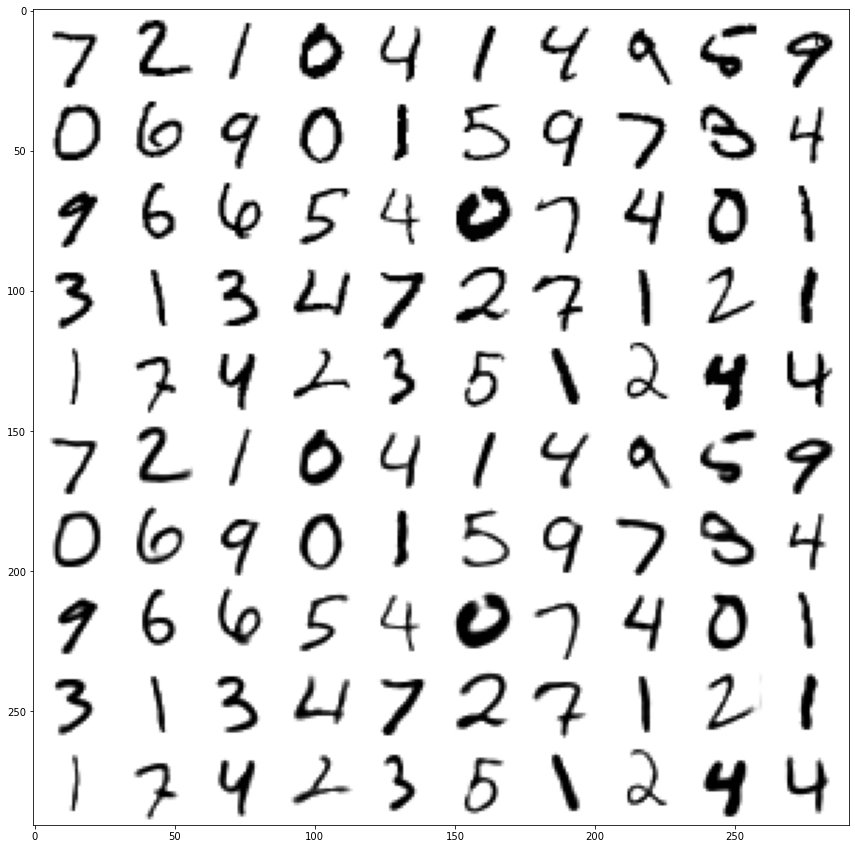

torch.Size([1280, 1, 28, 28])


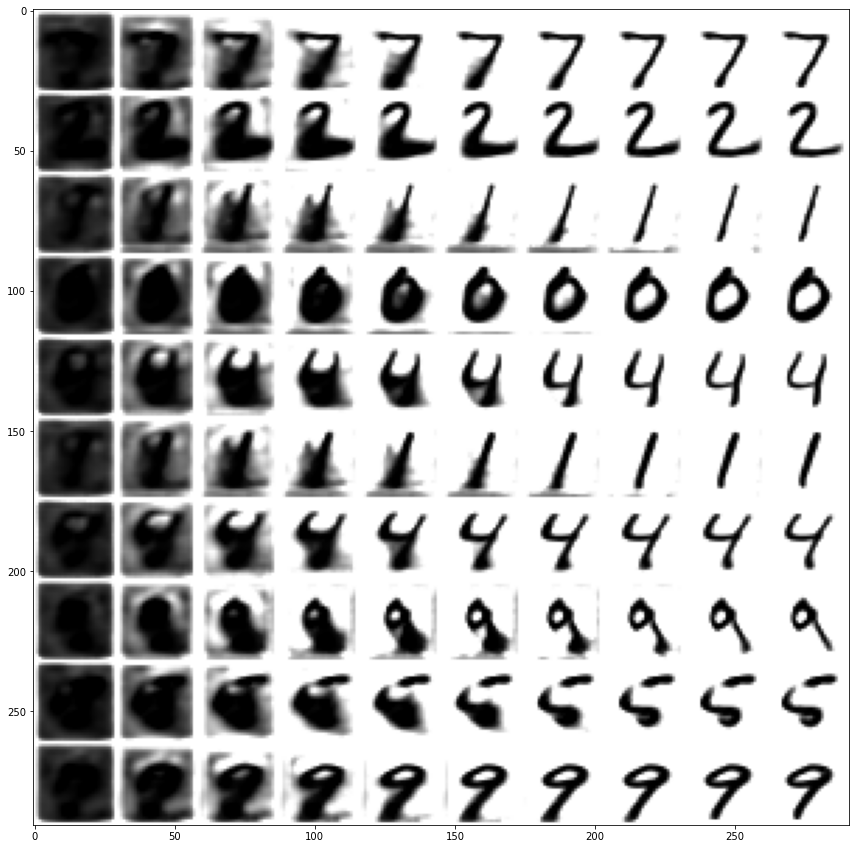

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

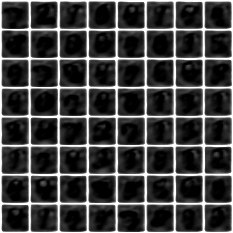

In [10]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# plot and save image outputs
img_g = torch.cat((x[:50].to(args.device),torch.sum(c_each,dim=1)[:50]))
img_g = make_grid(img_g, nrow=10, padding=1, normalize=False, pad_value=1)
save_name = 'image_grid_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size, args.time_steps, args.num_targets)
save_image(img_g, os.path.join(args.output_dir, save_name))
img_g = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(img_g) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# reconstructoin steps
c_cumu_step = []
for i in range(args.time_steps):
    c_cumu_step.append(torch.squeeze(torch.cumsum(c_each,dim=1).narrow(1,i,1)))
        
        
num_imgs = 10
images = torch.stack(c_cumu_step, dim=1).view(-1, *args.image_dims)  # reshape to (10*time_steps, 1, 28, 28)
print(images.shape)
images = make_grid(images[0:num_imgs*len(c_cumu_step)], nrow=len(c_cumu_step), padding=1, normalize=False, pad_value=1)
save_name = 'generated_sequences_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size,args.time_steps,args.num_targets)


save_image(images, os.path.join(args.output_dir, save_name))
images = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(images) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# make gif
num_imgs = 64
c_cumu_step_gif = copy.deepcopy(c_cumu_step)
for i in range(len(c_cumu_step)):
    # convert sequence of image tensors to 8x8 grid
    image = make_grid(c_cumu_step[i][:num_imgs].view(-1, *args.image_dims).clip(max=1).cpu(), \
                      nrow=int(math.sqrt(num_imgs)), padding=1, normalize=False, pad_value=1)
    # make into gif
    c_cumu_step_gif[i] = image.data.numpy().transpose(1,2,0)

import imageio
file_add = (os.path.join(args.output_dir, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
imageio.mimsave(file_add, c_cumu_step_gif)

IP_Image(open(file_add,'rb').read(), width = 600, height = 600)

## Plotting attention windows for all timesteps 


****************************************************************************************************
trial 0

ground truth
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor(7)
model prediction
tensor([0.0759, 0.0991, 0.0874, 0.0783, 0.0715, 0.0901, 0.1008, 1.3071, 0.0801,
        0.0743])
tensor([False, False, False, False, False, False, False,  True, False, False])
tensor(7)
partial score, 1.0, exact score, True


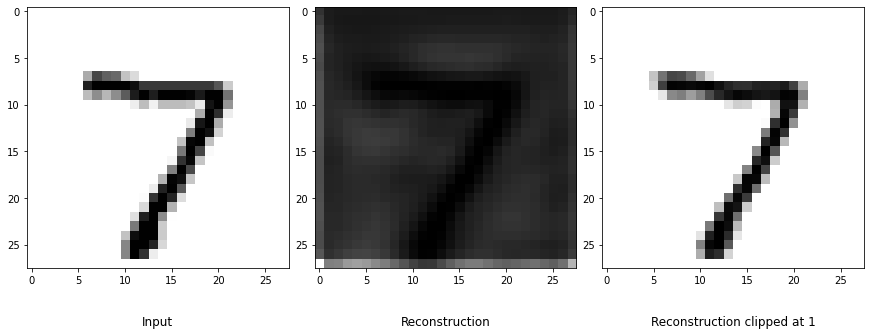

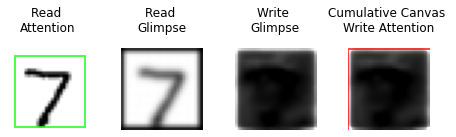

tensor([0.0084, 0.0227, 0.0102, 0.0122, 0.0075, 0.0202, 0.0260, 0.0359, 0.0091,
        0.0166])
tensor([7, 6, 1, 5, 9, 3, 2, 8, 0, 4])


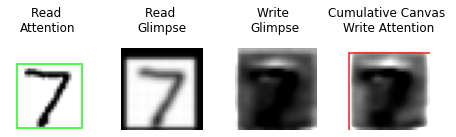

tensor([0.0098, 0.0151, 0.0098, 0.0100, 0.0068, 0.0078, 0.0168, 0.0469, 0.0086,
        0.0115])
tensor([7, 6, 1, 9, 3, 0, 2, 8, 5, 4])


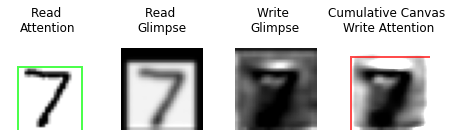

tensor([0.0141, 0.0086, 0.0091, 0.0092, 0.0093, 0.0114, 0.0093, 0.0531, 0.0062,
        0.0115])
tensor([7, 0, 9, 5, 4, 6, 3, 2, 1, 8])


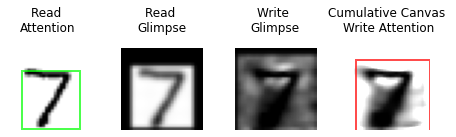

tensor([0.0101, 0.0084, 0.0077, 0.0112, 0.0094, 0.0111, 0.0092, 0.0798, 0.0068,
        0.0082])
tensor([7, 3, 5, 0, 4, 6, 1, 9, 2, 8])


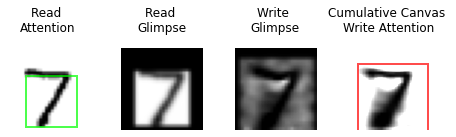

tensor([0.0107, 0.0097, 0.0131, 0.0095, 0.0065, 0.0106, 0.0108, 0.1074, 0.0111,
        0.0048])
tensor([7, 2, 8, 6, 0, 5, 1, 3, 4, 9])


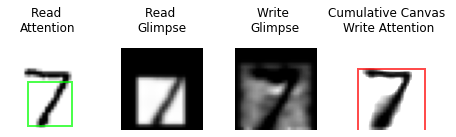

tensor([0.0064, 0.0116, 0.0105, 0.0068, 0.0038, 0.0074, 0.0070, 0.1379, 0.0153,
        0.0040])
tensor([7, 8, 1, 2, 5, 6, 3, 0, 9, 4])


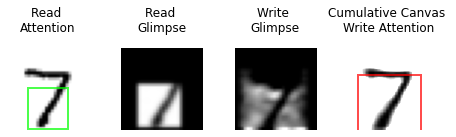

tensor([0.0062, 0.0094, 0.0090, 0.0080, 0.0043, 0.0086, 0.0086, 0.1918, 0.0103,
        0.0073])
tensor([7, 8, 1, 2, 5, 6, 3, 9, 0, 4])


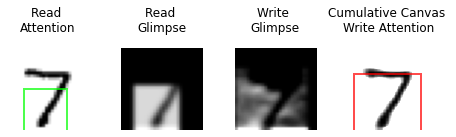

tensor([0.0030, 0.0065, 0.0074, 0.0045, 0.0150, 0.0063, 0.0089, 0.2088, 0.0055,
        0.0064])
tensor([7, 4, 6, 2, 1, 9, 5, 8, 3, 0])


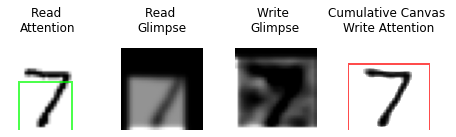

tensor([0.0044, 0.0054, 0.0093, 0.0048, 0.0071, 0.0034, 0.0034, 0.2344, 0.0036,
        0.0026])
tensor([7, 2, 4, 1, 3, 0, 8, 6, 5, 9])


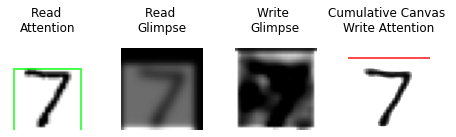

tensor([0.0028, 0.0019, 0.0013, 0.0020, 0.0017, 0.0031, 0.0008, 0.2111, 0.0035,
        0.0014])
tensor([7, 8, 5, 0, 3, 1, 4, 9, 2, 6])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0759, 0.0991, 0.0874, 0.0783, 0.0715, 0.0901, 0.1008, 1.3071, 0.0801,
        0.0743], device='cuda:0')
tensor([7, 6, 1, 5, 2, 8, 3, 0, 9, 4], device='cuda:0')

****************************************************************************************************
trial 1

ground truth
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor(2)
model prediction
tensor([0.0840, 0.0902, 1.5454, 0.0888, 0.0799, 0.0840, 0.0864, 0.0860, 0.0899,
        0.0897])
tensor([False, False,  True, False, False, False, False, False, False, False])
tensor(2)
partial score, 1.0, exact score, True


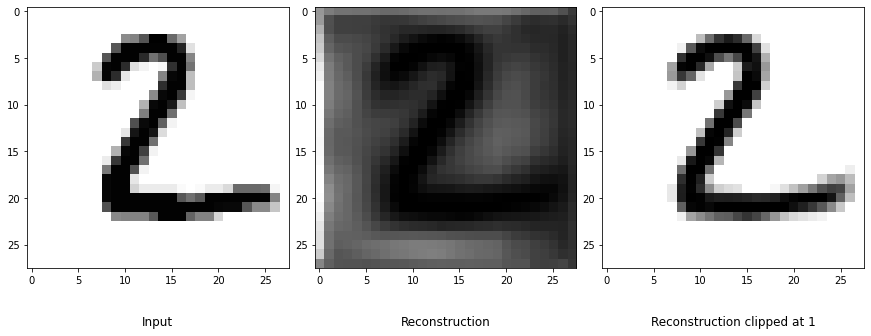

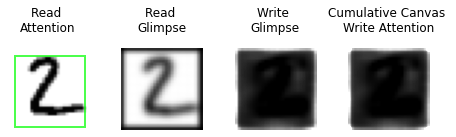

tensor([0.0079, 0.0122, 0.1004, 0.0172, 0.0070, 0.0140, 0.0148, 0.0147, 0.0125,
        0.0115])
tensor([2, 3, 6, 7, 5, 8, 1, 9, 0, 4])


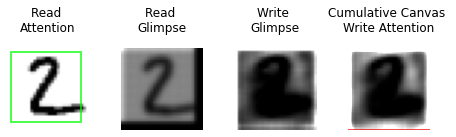

tensor([0.0103, 0.0139, 0.0773, 0.0163, 0.0106, 0.0073, 0.0106, 0.0096, 0.0058,
        0.0129])
tensor([2, 3, 1, 9, 4, 6, 0, 7, 5, 8])


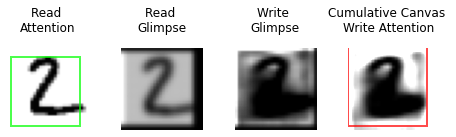

tensor([0.0082, 0.0099, 0.0945, 0.0087, 0.0028, 0.0067, 0.0110, 0.0123, 0.0101,
        0.0124])
tensor([2, 9, 7, 6, 8, 1, 3, 0, 5, 4])


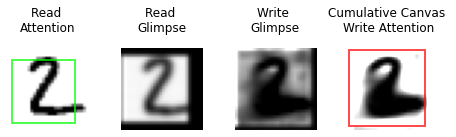

tensor([0.0098, 0.0078, 0.1406, 0.0099, 0.0049, 0.0106, 0.0134, 0.0145, 0.0133,
        0.0136])
tensor([2, 7, 9, 6, 8, 5, 3, 0, 1, 4])


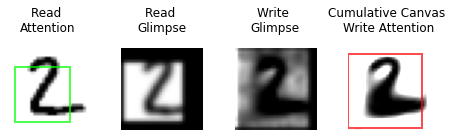

tensor([0.0112, 0.0146, 0.1613, 0.0101, 0.0103, 0.0095, 0.0116, 0.0151, 0.0130,
        0.0115])
tensor([2, 7, 1, 8, 6, 9, 0, 4, 3, 5])


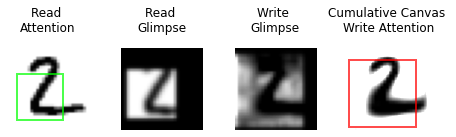

tensor([0.0169, 0.0194, 0.1818, 0.0119, 0.0085, 0.0125, 0.0077, 0.0080, 0.0120,
        0.0109])
tensor([2, 1, 0, 5, 8, 3, 9, 4, 7, 6])


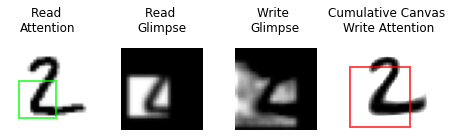

tensor([0.0114, 0.0063, 0.1823, 0.0041, 0.0086, 0.0066, 0.0064, 0.0039, 0.0091,
        0.0081])
tensor([2, 0, 8, 4, 9, 5, 6, 1, 3, 7])


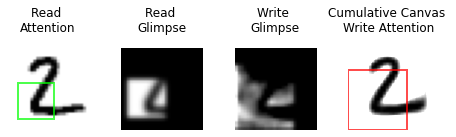

tensor([0.0047, 0.0023, 0.2211, 0.0051, 0.0137, 0.0079, 0.0074, 0.0050, 0.0086,
        0.0054])
tensor([2, 4, 8, 5, 6, 9, 3, 7, 0, 1])


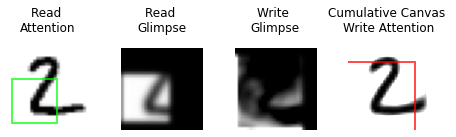

tensor([0.0018, 0.0027, 0.2177, 0.0027, 0.0081, 0.0060, 0.0020, 0.0019, 0.0036,
        0.0019])
tensor([2, 4, 5, 8, 1, 3, 6, 9, 7, 0])


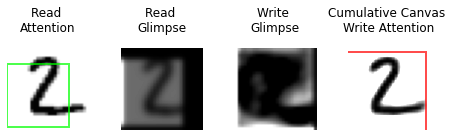

tensor([0.0017, 0.0011, 0.1685, 0.0029, 0.0054, 0.0028, 0.0014, 0.0012, 0.0018,
        0.0015])
tensor([2, 4, 3, 5, 8, 0, 9, 6, 7, 1])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0840, 0.0902, 1.5454, 0.0888, 0.0799, 0.0840, 0.0864, 0.0860, 0.0899,
        0.0897], device='cuda:0')
tensor([2, 1, 8, 9, 3, 6, 7, 0, 5, 4], device='cuda:0')

****************************************************************************************************
trial 2

ground truth
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(1)
model prediction
tensor([0.0785, 1.0368, 0.0850, 0.0694, 0.1052, 0.0859, 0.0772, 0.0927, 0.0851,
        0.0838])
tensor([False,  True, False, False, False, False, False, False, False, False])
tensor(1)
partial score, 1.0, exact score, True


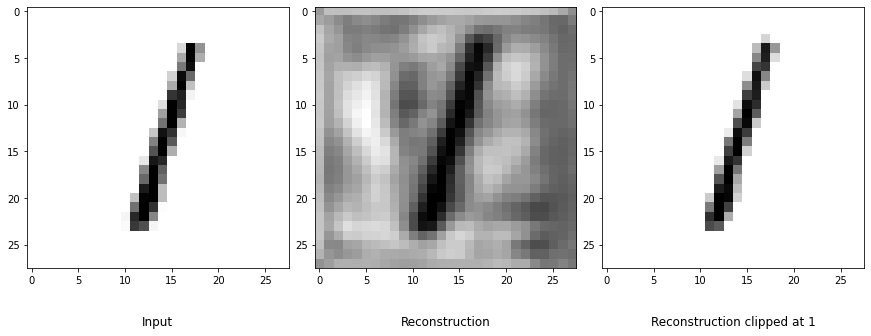

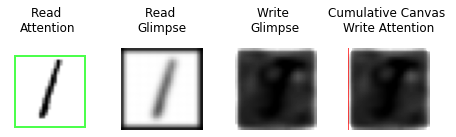

tensor([0.0121, 0.0555, 0.0138, 0.0117, 0.0203, 0.0070, 0.0156, 0.0105, 0.0099,
        0.0188])
tensor([1, 4, 9, 6, 2, 0, 3, 7, 8, 5])


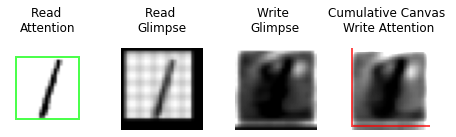

tensor([0.0095, 0.0413, 0.0065, 0.0097, 0.0233, 0.0090, 0.0095, 0.0089, 0.0113,
        0.0118])
tensor([1, 4, 9, 8, 3, 6, 0, 5, 7, 2])


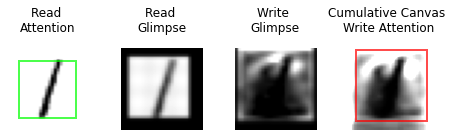

tensor([0.0097, 0.0556, 0.0059, 0.0055, 0.0113, 0.0109, 0.0108, 0.0105, 0.0066,
        0.0075])
tensor([1, 4, 5, 6, 7, 0, 9, 8, 2, 3])


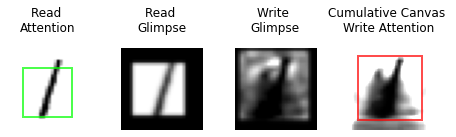

tensor([0.0092, 0.0795, 0.0050, 0.0045, 0.0164, 0.0095, 0.0077, 0.0113, 0.0066,
        0.0051])
tensor([1, 4, 7, 5, 0, 6, 8, 9, 2, 3])


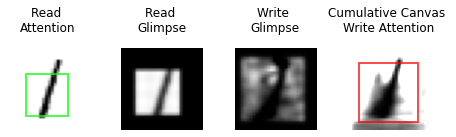

tensor([0.0090, 0.0839, 0.0051, 0.0037, 0.0097, 0.0079, 0.0055, 0.0083, 0.0089,
        0.0060])
tensor([1, 4, 0, 8, 7, 5, 9, 6, 2, 3])


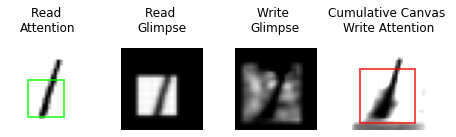

tensor([0.0063, 0.1044, 0.0085, 0.0069, 0.0070, 0.0125, 0.0057, 0.0117, 0.0097,
        0.0082])
tensor([1, 5, 7, 8, 2, 9, 4, 3, 0, 6])


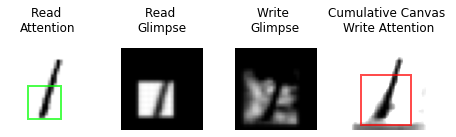

tensor([0.0040, 0.1154, 0.0120, 0.0039, 0.0038, 0.0084, 0.0038, 0.0122, 0.0113,
        0.0055])
tensor([1, 7, 2, 8, 5, 9, 0, 3, 6, 4])


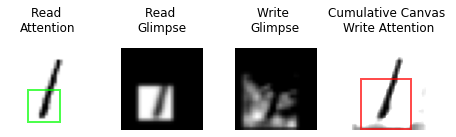

tensor([0.0073, 0.1070, 0.0178, 0.0097, 0.0052, 0.0114, 0.0090, 0.0145, 0.0090,
        0.0095])
tensor([1, 2, 7, 5, 3, 9, 8, 6, 0, 4])


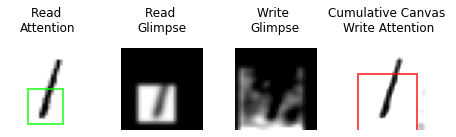

tensor([0.0060, 0.1744, 0.0060, 0.0071, 0.0031, 0.0040, 0.0040, 0.0011, 0.0035,
        0.0082])
tensor([1, 9, 3, 2, 0, 5, 6, 8, 4, 7])


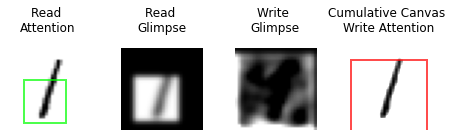

tensor([0.0055, 0.2197, 0.0046, 0.0068, 0.0053, 0.0053, 0.0055, 0.0037, 0.0083,
        0.0032])
tensor([1, 8, 3, 0, 6, 5, 4, 2, 7, 9])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0785, 1.0368, 0.0850, 0.0694, 0.1052, 0.0859, 0.0772, 0.0927, 0.0851,
        0.0838], device='cuda:0')
tensor([1, 4, 7, 5, 8, 2, 9, 0, 6, 3], device='cuda:0')

****************************************************************************************************
trial 3

ground truth
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0)
model prediction
tensor([1.1514, 0.1147, 0.0953, 0.0974, 0.0893, 0.0906, 0.1051, 0.0986, 0.0661,
        0.0835])
tensor([ True, False, False, False, False, False, False, False, False, False])
tensor(0)
partial score, 1.0, exact score, True


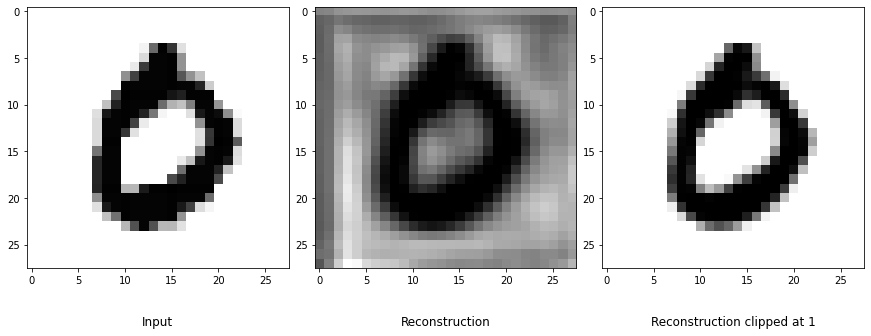

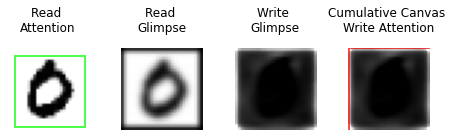

tensor([0.0147, 0.0194, 0.0069, 0.0050, 0.0079, 0.0085, 0.0258, 0.0250, 0.0052,
        0.0077])
tensor([6, 7, 1, 0, 5, 4, 9, 2, 8, 3])


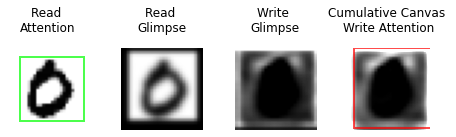

tensor([0.0211, 0.0111, 0.0166, 0.0047, 0.0084, 0.0074, 0.0123, 0.0084, 0.0052,
        0.0088])
tensor([0, 2, 6, 1, 9, 7, 4, 5, 8, 3])


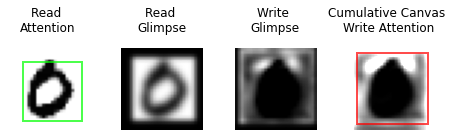

tensor([0.0314, 0.0183, 0.0131, 0.0095, 0.0095, 0.0124, 0.0121, 0.0094, 0.0055,
        0.0126])
tensor([0, 1, 2, 9, 5, 6, 4, 3, 7, 8])


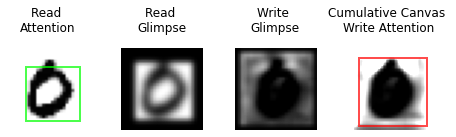

tensor([0.0441, 0.0153, 0.0079, 0.0145, 0.0092, 0.0068, 0.0072, 0.0086, 0.0070,
        0.0054])
tensor([0, 1, 3, 4, 7, 2, 6, 8, 5, 9])


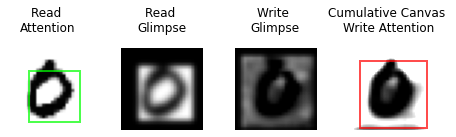

tensor([0.1000, 0.0192, 0.0109, 0.0091, 0.0090, 0.0145, 0.0185, 0.0153, 0.0089,
        0.0123])
tensor([0, 1, 6, 7, 5, 9, 2, 3, 4, 8])


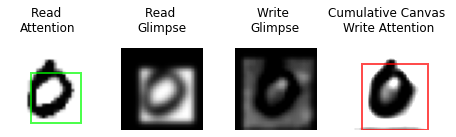

tensor([0.1090, 0.0078, 0.0119, 0.0148, 0.0094, 0.0143, 0.0113, 0.0082, 0.0070,
        0.0074])
tensor([0, 3, 5, 2, 6, 4, 7, 1, 9, 8])


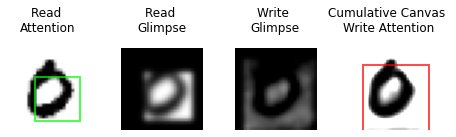

tensor([0.1755, 0.0124, 0.0137, 0.0149, 0.0172, 0.0132, 0.0090, 0.0111, 0.0099,
        0.0128])
tensor([0, 4, 3, 2, 5, 9, 1, 7, 8, 6])


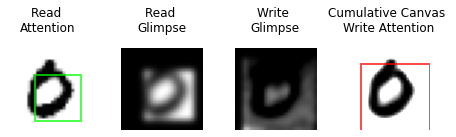

tensor([0.2050, 0.0059, 0.0098, 0.0143, 0.0139, 0.0092, 0.0060, 0.0071, 0.0106,
        0.0104])
tensor([0, 3, 4, 8, 9, 2, 5, 7, 6, 1])


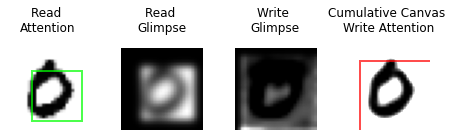

tensor([0.2388, 0.0022, 0.0031, 0.0066, 0.0034, 0.0030, 0.0020, 0.0029, 0.0052,
        0.0037])
tensor([0, 3, 8, 9, 4, 2, 5, 7, 1, 6])


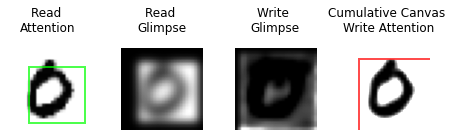

tensor([0.2119, 0.0031, 0.0014, 0.0042, 0.0015, 0.0013, 0.0009, 0.0025, 0.0015,
        0.0024])
tensor([0, 3, 1, 7, 9, 8, 4, 2, 5, 6])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.1514, 0.1147, 0.0953, 0.0974, 0.0893, 0.0906, 0.1051, 0.0986, 0.0661,
        0.0835], device='cuda:0')
tensor([0, 1, 6, 7, 3, 2, 5, 4, 9, 8], device='cuda:0')

****************************************************************************************************
trial 4

ground truth
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor(4)
model prediction
tensor([0.0978, 0.1014, 0.0792, 0.1188, 1.0603, 0.0688, 0.0996, 0.1006, 0.0791,
        0.0951])
tensor([False, False, False, False,  True, False, False, False, False, False])
tensor(4)
partial score, 1.0, exact score, True


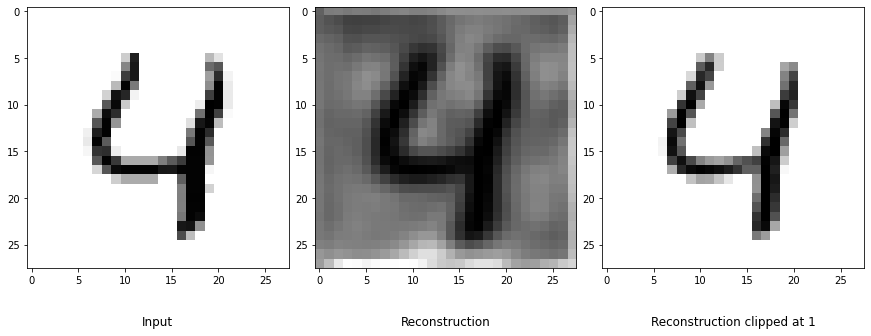

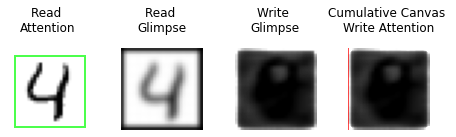

tensor([0.0131, 0.0126, 0.0119, 0.0113, 0.0406, 0.0106, 0.0331, 0.0136, 0.0085,
        0.0097])
tensor([4, 6, 7, 0, 1, 2, 3, 5, 9, 8])


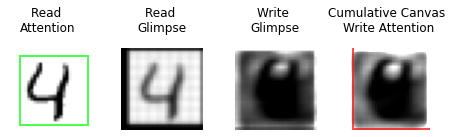

tensor([0.0136, 0.0157, 0.0121, 0.0077, 0.0398, 0.0082, 0.0091, 0.0095, 0.0063,
        0.0102])
tensor([4, 1, 0, 2, 9, 7, 6, 5, 3, 8])


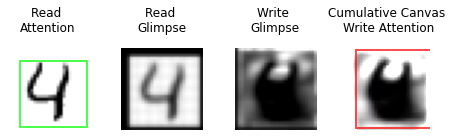

tensor([0.0144, 0.0135, 0.0106, 0.0074, 0.0384, 0.0104, 0.0142, 0.0149, 0.0101,
        0.0125])
tensor([4, 7, 0, 6, 1, 9, 2, 5, 8, 3])


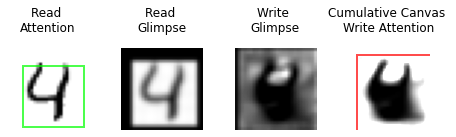

tensor([0.0118, 0.0113, 0.0098, 0.0133, 0.0644, 0.0071, 0.0138, 0.0127, 0.0088,
        0.0143])
tensor([4, 9, 6, 3, 7, 0, 1, 2, 8, 5])


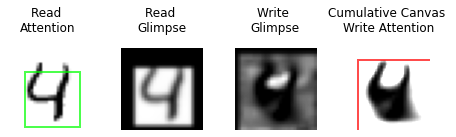

tensor([0.0157, 0.0198, 0.0123, 0.0121, 0.1039, 0.0066, 0.0117, 0.0176, 0.0099,
        0.0151])
tensor([4, 1, 7, 0, 9, 2, 3, 6, 8, 5])


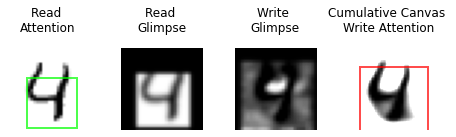

tensor([0.0081, 0.0131, 0.0026, 0.0148, 0.1191, 0.0065, 0.0040, 0.0160, 0.0120,
        0.0114])
tensor([4, 7, 3, 1, 8, 9, 0, 5, 6, 2])


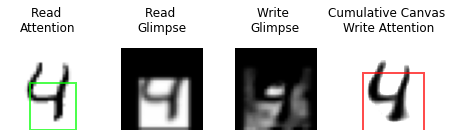

tensor([0.0053, 0.0044, 0.0064, 0.0311, 0.1394, 0.0110, 0.0036, 0.0056, 0.0107,
        0.0067])
tensor([4, 3, 5, 8, 9, 2, 7, 0, 1, 6])


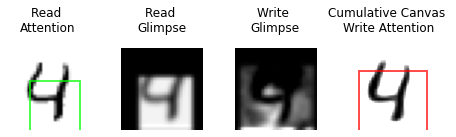

tensor([0.0097, 0.0059, 0.0048, 0.0128, 0.1886, 0.0035, 0.0069, 0.0060, 0.0066,
        0.0066])
tensor([4, 3, 0, 6, 8, 9, 7, 1, 2, 5])


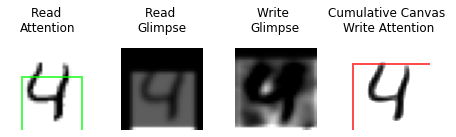

tensor([0.0034, 0.0041, 0.0077, 0.0048, 0.1768, 0.0026, 0.0019, 0.0035, 0.0045,
        0.0063])
tensor([4, 2, 9, 3, 8, 1, 7, 0, 5, 6])


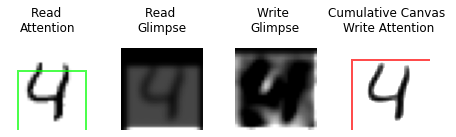

tensor([0.0026, 0.0009, 0.0011, 0.0035, 0.1494, 0.0021, 0.0014, 0.0012, 0.0017,
        0.0025])
tensor([4, 3, 0, 9, 5, 8, 6, 7, 2, 1])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0978, 0.1014, 0.0792, 0.1188, 1.0603, 0.0688, 0.0996, 0.1006, 0.0791,
        0.0951], device='cuda:0')
tensor([4, 3, 1, 7, 6, 0, 9, 2, 8, 5], device='cuda:0')


In [11]:
import matplotlib.gridspec as gridspec

num_trials = 5
idtrial_incorrect = []
save_plot = 0
create_gif = 0
fig_folder = args.output_dir + 'mm_3/'  # folder to save figs/gifs

if args.use_read_attn == False:
    args.read_size = args.image_dims[1]

if args.use_write_attn == False:
    args.write_size = args.image_dims[1]

y_pred_nars = y_pred.narrow(1,0,args.num_classes) 
y_pred_hots, _ , paccs , _, eaccs = cal_accs(y_pred_nars, y.to(args.device), readout_logits, args)

for i in range(num_trials): #len(y)):

    y_true = y[i].cpu()

    if torch.max(y_true) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_os = torch.squeeze(torch.nonzero(torch.squeeze(y_true)))
    else:
        y_os = torch.cat( (torch.nonzero(torch.squeeze(y_true))[0], torch.nonzero(torch.squeeze(y_true))[0]))

    y_pred_hot = y_pred_hots[i].cpu()
    y_pred_nar = y_pred_nars[i].cpu()
    if torch.max(y_pred_hot) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_pred_os = torch.squeeze(torch.nonzero(torch.squeeze(y_pred_hot)))
    else:
        y_pred_os = torch.cat( (torch.nonzero(torch.squeeze(y_pred_hot))[0], torch.nonzero(torch.squeeze(y_pred_hot))[0]))

    correct_partial = paccs[i].cpu()
    correct_exact = eaccs[i].cpu()

    # print only incorrect trials 
#     if correct_exact == 1:
#         continue 
#     idtrial_incorrect.append(i)
        
    print('\n' + '*'*100)
    print('trial ' + str(i))
        
    print('\nground truth')
    print(y_true)
    print(y_os)
    
    print('model prediction')
    print(y_pred_nar)
    print(y_pred_hot)
    print(y_pred_os)
        
    print(f'partial score, {correct_partial}, exact score, {correct_exact}')
    
        
    g_h = 1
    g_w = 3
    fig = plt.figure(figsize=(15,6))
    gs1 = gridspec.GridSpec(g_h, g_w)
    gs1.update(wspace=0.1, hspace=0.1)  # set the spacing between axes.

    ax = plt.subplot(gs1[0,0])
    ax.imshow(torch.squeeze(x[i].movedim(0,-1)), cmap='gray')
    ax.text(0.5,-0.22,  "Input", size=12, ha="center", transform=ax.transAxes)

    ax = plt.subplot(gs1[0,1])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction", size=12, ha="center", transform=ax.transAxes)
    
    ax = plt.subplot(gs1[0,2])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), vmin=0, vmax=1, cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction clipped at 1", size=12, ha="center", transform=ax.transAxes)
    
    plt.show()
    

    #--------------------------------------
    # plotting read and  write operatoins 
    
    
    for j in range(args.time_steps):
        
        g_h = 1
        g_w = 5
        fig = plt.figure(figsize=(10,1.5))
        gs1 = gridspec.GridSpec(g_h, g_w)
        gs1.update(wspace=0.1, hspace=0.1)

        class_l = torch.zeros((args.time_steps, args.num_classes+args.backg_objcaps))
    
        ax = plt.subplot(gs1[0,0])
        
#         if args.task == 'MultiMNIST_tracking':
#             print(x[i].shape)
#             x_t = x[i].narrow(0,j,1)
            
#         else:
        x_t = x[i]

        ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
        ax.axis('off')
        
        ax.text(0.5,1.2,  "Read \nAttention", \
        size=12, ha="center", transform=ax.transAxes)
        
        #if args.use_glimpse_attn:
        if args.use_read_attn:
            mu_x = read_mu_xs[j][i]
            mu_y = read_mu_ys[j][i]

            r_x = mu_x[0]
            r_y = mu_y[0]
            r_w = mu_y[-1] - mu_y[0]
            r_h = mu_x[-1] - mu_x[0]

            ax.add_patch(Rectangle((r_x, r_y), r_w, r_h, facecolor='none', edgecolor='lime', linewidth=2, alpha=0.7))
            #-------------------------------------

#         if args.use_soft_attn:
#             p = j*step_num 
#             soft_map = att_param[p][7][i].cpu().numpy()
            
#             soft_map = np.reshape(soft_map, (8, 8))
#             plt.imshow(soft_map)
#             plt.show()
#             print(len(soft_map))
#             print(soft_map[0].shape)
#             break

            
        ax = plt.subplot(gs1[0,1])
        ax.imshow(read_x_step[i][j].movedim(0,-1).cpu(), cmap='gray')
        ax.axis('off')
        #if j==0:
        ax.text(0.5,1.2,  "Read \nGlimpse", \
        size=12, ha="center", transform=ax.transAxes)
            
        
        #---------------------------------------
        if args.recon_model:
            #im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), (args.image_dims[1],args.image_dims[2]))
            im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), \
                                (args.image_dims[0], args.image_dims[1],args.image_dims[2])).transpose(1,2,0)

            ax = plt.subplot(gs1[0,3])
            ax.imshow(im, vmin=0, vmax=1 , cmap='gray')  # max(np.max(im),1)
            ax.axis('off')

            #if j==0:
            ax.text(0.5,1.2,  "Cumulative Canvas \nWrite Attention", \
            size=12, ha="center", transform=ax.transAxes)
            
            if args.use_write_attn:
                mu_x = write_mu_xs[j][i]
                mu_y = write_mu_ys[j][i]

                w_x = mu_x[0]
                w_y = mu_y[0]
                w_w = mu_y[-1] - mu_y[0]
                w_h = mu_x[-1] - mu_x[0]

                ax.add_patch(Rectangle((w_x, w_y), w_w, w_h, facecolor='none', edgecolor='red', linewidth=2, alpha=0.7))
                
                c_each = torch.clip(c_each, min=0, max=1)

                ax = plt.subplot(gs1[0,2])
                ax.imshow(c_each[i][j].movedim(0,-1).cpu(), vmin=0, vmax=1, cmap='gray')
                ax.axis('off')
                #if j==0:
                ax.text(0.5,1.2,  "Write \nGlimpse", \
                size=12, ha="center", transform=ax.transAxes)
        
#                 if args.task == 'MultiMNIST_tracking':
#                     x_t = x[i].narrow(0,j+1,1)
#                     ax = plt.subplot(gs1[j,5])
#                     ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
                        


        if save_plot:
            
            plt.margins(0,0)    
            save_folder = fig_folder + str(i) + '/'
            if not os.path.isdir(save_folder):
                os.makedirs(save_folder)
            fig.savefig( save_folder + 'image{:02d}'.format(j) + '.png', bbox_inches='tight', pad_inches=0.0)

        plt.show()
        
        class_l[j,:] = objcaps_len_step[i][j]
        class_sorted, indices = torch.sort(class_l[j,:], dim=0, descending=True)

        print(class_l[j,:])  # .cpu().numpy()
        print(indices)   # .cpu().numpy()
        #print('_ ' * 40 + '\n')
    
    print('_ ' * 40 + '\n')
    class_l_sum = torch.sum(objcaps_len_step[i],dim=0)
    print(class_l_sum)
    class_sorted_sum, indices_sum = torch.sort(class_l_sum, dim=0, descending=True)
    print(indices_sum)
        
    if save_plot:    
        if create_gif:  

            import imageio
            from PIL import Image
            import glob
            image_list = []
            for filename in glob.glob(save_folder+ '/*.png'): #assuming gif
                im=Image.open(filename)
                image_list.append(np.array(im))


            file_add = (os.path.join(save_folder, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
            imageio.mimsave(file_add, image_list, duration=0.4)


            #print("The accuracy for this batch is: " + str(test_acc) )

            IP_Image(open(file_add,'rb').read(), width = 600, height = 600)
    
    
    

# Applying the model to controversial Stimuli 

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt

import pandas as pd
from PIL import Image, ImageOps
import torch
import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, TensorDataset

data_dir = './data/' + 'mnist_controversial/'

ex_folder = './PNAS_2020_Controversial_Stimuli-master/experiment_1_results/' 
img_folder = ex_folder + 'stimuli_presented_in_behavioral_experiment/'

data_csv = ex_folder + 'Experiment_1_human_responses.csv'
df = pd.read_csv(data_csv)

subjects = np.unique(df['subject'])

img_names = np.load(data_dir + 'controversial_stimuli_names.npy')

tensor_test_ims = torch.load(data_dir + 'mnist_controversial.pt')

kwargs = {'num_workers': 0, 'pin_memory': True} 

test_dataset = TensorDataset(tensor_test_ims) 
test_dataloader = DataLoader(test_dataset, batch_size=128, **kwargs) # create your dataloader


outPRED = torch.FloatTensor().to(args.device)
L_recon_all = torch.FloatTensor().to(args.device)

# load batch data
for x in test_dataloader:

    x = x[0].to(args.device)
    # evaluate
    
    with torch.no_grad():
        objcaps_len_step, read_x_step, c_step, _ = model(x)
        y_pred = torch.sum(objcaps_len_step, dim=1)
        c = torch.sum(c_step, dim=1)
        # compute loss    
        y_pred_nar = y_pred.narrow(1,0,args.num_classes) # in case a background cap was added, narrow the tensor before passing it to the loss function 

        #loss, L_recon, L_margin = loss_fn(c, c_each_step, recon_mask, x, y_pred_nar, y_pred_nar, args)   

        #clip the predicted cumulative canvas so that the model can overlap object reconstructions without increasing error
        if (args.clip_c):
            c = torch.clip(c,0,1)

        x = x.view(x.shape[0],-1)
        c = c.view(c.shape[0],-1)
        # weight the reconstruction error before adding it to the classification loss
        # loss_f = nn.MSELoss(reduction='none')
        L_recon = args.lam_recon * nn.MSELoss(reduction='none')(c, x)  
        L_recon = torch.mean(L_recon, dim=1)

        #loss, L_recon, L_margin = loss_fn(c, c_each_step, recon_mask, x, y_pred_nar, y_pred_nar, args)   

        #c = torch.reshape(torch.clip(c,0,1).detach(), (1, *args.image_dims))   #to plot

        outPRED = torch.cat((outPRED, y_pred_nar), 0)
        L_recon_all = torch.cat((L_recon_all, L_recon), 0)
    

c_factor = torch.zeros_like(L_recon_all)

# for i in range(len(L_recon_all)):
#     if L_recon_all[i] < 0.6:
#         c_factor[i] = 1
#     else:
#         c_factor[i] = 0


        
for i in range(len(L_recon_all)):
    if L_recon_all[i] < 0.1:
        c_factor[i] = 1
    elif L_recon_all[i] > 0.6:
        c_factor[i] = 0
    else:
        c_factor[i] = 1 - (2* (L_recon_all[i] - 0.1))
        
        

y_preds = 2 * (torch.clip(outPRED,.5,1)  - 0.5)

y_preds = torch.unsqueeze(c_factor, 1).expand(-1,10) * y_preds

y_preds = torch.reshape(y_preds.detach(), (-1,)).cpu().numpy()
np.mean(y_preds)

model_data = {'image':np.repeat(img_names,10),
        'category':np.tile([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],len(img_names)),
        'predictions':y_preds}

model_df = pd.DataFrame(model_data)


r_ms_all = np.zeros(len(subjects))
for i in range(30): #len(subjects)):
    
    sub_name = subjects[i]

    df_s = df[ (df['subject']==sub_name) & (df['image_repetition']==0)]
    df_sm= pd.merge(df_s, model_df, on=['image','category'], how='inner')

    sub_r = df_sm['rating'].to_numpy()
    model_p = df_sm['predictions'].to_numpy()
    
    denom = np.sqrt(np.sum(np.square(sub_r - np.mean(sub_r)))) * np.sqrt(np.sum(np.square(model_p - np.mean(model_p))))
    r_ms = np.sum ( (sub_r - np.mean(sub_r)) * (model_p - np.mean(model_p)) ) / denom
    
    r_ms_all[i] = r_ms
    
    
# L_recon_all  = L_recon_all.detach().cpu().numpy()
# outPRED = outPRED

print(r_ms_all)
    
print('average correlation')
print(np.mean(r_ms_all))

[0.83333827 0.81204082 0.70641663 0.81847352 0.79031366 0.86397266
 0.85715229 0.79621771 0.79179212 0.83238078 0.80293405 0.76153518
 0.79175256 0.87655058 0.87116177 0.74853661 0.87537852 0.84695078
 0.8718827  0.84348444 0.82240871 0.80541321 0.84225035 0.81616198
 0.84706234 0.80507382 0.87041863 0.8448976  0.8696795  0.83189094]
average correlation
0.82491742410419


madry_adv_trained_3_small_VGG_negative_6
tensor([[0.2711, 0.4674, 0.2782, 0.2236, 0.1412, 0.3746, 0.1524, 0.1362, 0.7906,
         0.1727]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.8929], device='cuda:0')
tensor([0.], device='cuda:0')


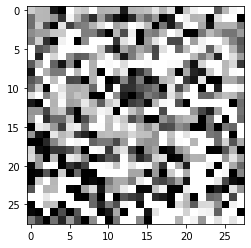

madry_adv_trained_3_small_VGG_negative_8
tensor([[0.2377, 0.4528, 0.2272, 0.4844, 0.1153, 0.2218, 0.1202, 0.2162, 0.4645,
         0.1814]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.1492], device='cuda:0')
tensor([0.], device='cuda:0')


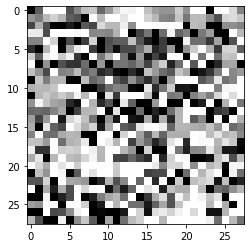

madry_adv_trained_4_madry_l2_2
tensor([[0.1397, 0.0621, 1.5486, 0.0881, 0.1031, 0.0920, 0.1332, 0.0772, 0.1145,
         0.0854]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.5171], device='cuda:0')
tensor([0.], device='cuda:0')


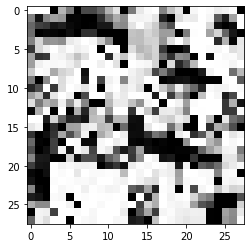

madry_adv_trained_4_madry_l2_3
tensor([[0.1057, 0.1461, 0.0973, 1.0493, 0.1058, 0.1177, 0.1058, 0.1439, 0.1564,
         0.1021]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.4784], device='cuda:0')
tensor([0.], device='cuda:0')


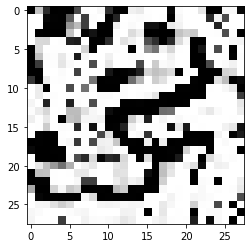

madry_adv_trained_4_schott_VAE_1
tensor([[0.0527, 1.0992, 0.0822, 0.0580, 0.0959, 0.0900, 0.0792, 0.0803, 0.0911,
         0.0917]], device='cuda:0')
[0.        0.9614698 0.        0.        0.        0.        0.
 0.        0.        0.       ]
[0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.  ]
tensor([0.1193], device='cuda:0')
tensor([0.9615], device='cuda:0')


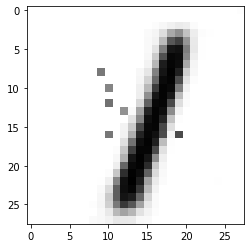

madry_adv_trained_4_schott_VAE_7
tensor([[0.0596, 0.0656, 0.0589, 0.0578, 0.0711, 0.0603, 0.0685, 1.1394, 0.0548,
         0.0749]], device='cuda:0')
[0.         0.         0.         0.         0.         0.
 0.         0.99584275 0.         0.        ]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
tensor([0.1021], device='cuda:0')
tensor([0.9958], device='cuda:0')


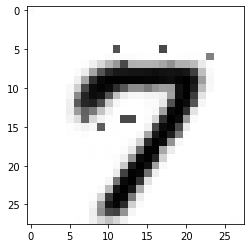

madry_adv_trained_4_small_VGG_6
tensor([[0.1644, 0.2015, 0.1199, 0.1946, 0.1037, 0.1766, 1.6447, 0.1029, 0.1679,
         0.0982]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.4456], device='cuda:0')
tensor([0.], device='cuda:0')


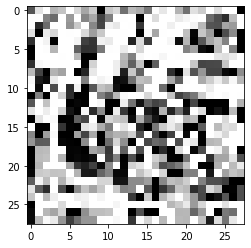

madry_adv_trained_4_small_VGG_8
tensor([[0.0919, 0.2295, 0.2233, 0.2315, 0.2510, 0.2731, 0.1026, 0.2210, 0.2395,
         0.1512]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.6622], device='cuda:0')
tensor([0.], device='cuda:0')


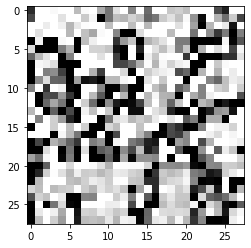

madry_adv_trained_4_small_VGG_negative_6
tensor([[0.1199, 0.2123, 0.1883, 0.1633, 0.4632, 0.1432, 0.0959, 0.1404, 0.2449,
         0.1176]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.5807], device='cuda:0')
tensor([0.], device='cuda:0')


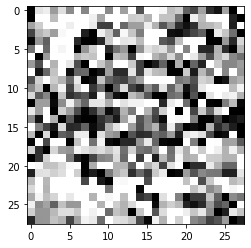

madry_adv_trained_4_small_VGG_negative_7
tensor([[0.0930, 0.1237, 0.1873, 0.0927, 0.0734, 0.1026, 0.1005, 0.0962, 0.8005,
         0.1176]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.3271], device='cuda:0')
tensor([0.], device='cuda:0')


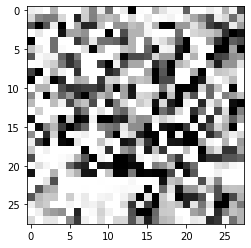

madry_adv_trained_5_madry_l2_3
tensor([[0.0983, 0.1208, 0.1662, 1.1654, 0.1121, 0.1432, 0.1599, 0.1085, 0.1295,
         0.1115]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.  ]
tensor([3.4526], device='cuda:0')
tensor([0.], device='cuda:0')


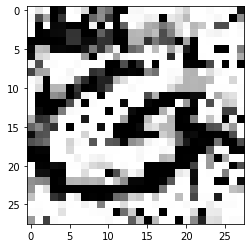

madry_adv_trained_5_madry_l2_9
tensor([[0.1801, 0.1941, 0.1614, 0.1967, 0.0984, 0.1774, 0.1302, 0.0948, 0.2446,
         0.9609]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([2.8460], device='cuda:0')
tensor([0.], device='cuda:0')


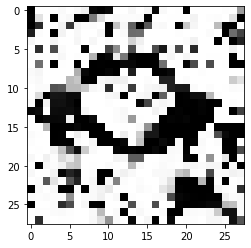

madry_adv_trained_5_schott_VAE_1
tensor([[0.0677, 1.1376, 0.0843, 0.0676, 0.0584, 0.0678, 0.0707, 0.0738, 0.0580,
         0.0750]], device='cuda:0')
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.0829], device='cuda:0')
tensor([1.], device='cuda:0')


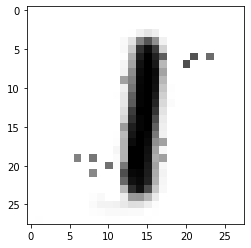

madry_adv_trained_5_schott_VAE_3
tensor([[0.0556, 0.0631, 0.0527, 1.0253, 0.0485, 0.0455, 0.0550, 0.0676, 0.0616,
         0.0502]], device='cuda:0')
[0.         0.         0.         0.87957716 0.         0.
 0.         0.         0.         0.        ]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
tensor([0.1602], device='cuda:0')
tensor([0.8796], device='cuda:0')


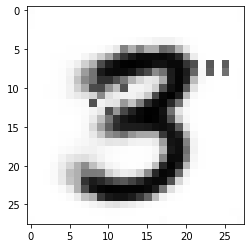

madry_adv_trained_5_small_VGG_3
tensor([[0.1664, 0.3314, 0.1609, 0.2111, 0.1121, 1.1217, 0.1209, 0.1424, 0.1987,
         0.1631]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.25 0.   0.   0.25 0.   0.   0.  ]
tensor([3.9737], device='cuda:0')
tensor([0.], device='cuda:0')


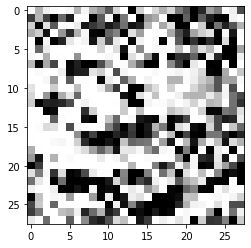

madry_adv_trained_5_small_VGG_9
tensor([[0.1375, 0.2360, 0.1073, 0.2179, 0.0995, 1.2550, 0.1091, 0.1483, 0.1388,
         0.1319]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.3088], device='cuda:0')
tensor([0.], device='cuda:0')


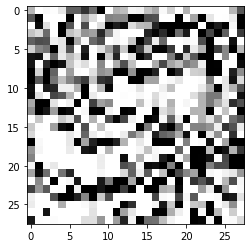

madry_adv_trained_5_small_VGG_negative_2
tensor([[0.2666, 0.4475, 0.3746, 0.2279, 0.1230, 0.2103, 0.1651, 0.1480, 0.7023,
         0.1182]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.4818], device='cuda:0')
tensor([0.], device='cuda:0')


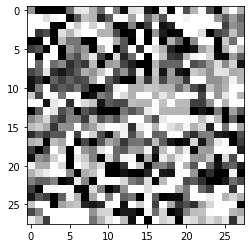

madry_adv_trained_5_small_VGG_negative_3
tensor([[0.1551, 0.3347, 0.2182, 0.3031, 0.0738, 0.2518, 0.0874, 0.2022, 0.4451,
         0.1775]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.0054], device='cuda:0')
tensor([0.], device='cuda:0')


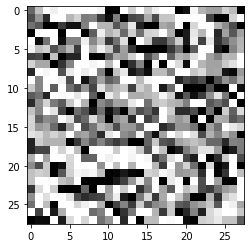

madry_adv_trained_6_madry_l2_4
tensor([[0.1656, 0.2644, 0.1477, 0.2469, 0.3400, 0.2091, 0.1359, 0.1710, 0.4771,
         0.1195]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.5000], device='cuda:0')
tensor([0.], device='cuda:0')


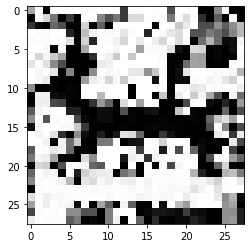

madry_adv_trained_6_madry_l2_7
tensor([[0.2147, 0.3749, 0.2300, 0.3453, 0.1377, 0.4851, 0.1597, 0.4532, 0.2982,
         0.2484]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.6329], device='cuda:0')
tensor([0.], device='cuda:0')


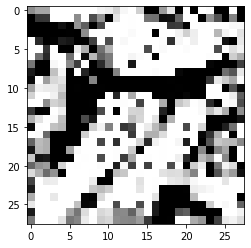

madry_adv_trained_6_schott_VAE_5
tensor([[0.0771, 0.0699, 0.0854, 0.0617, 0.0582, 1.1604, 0.0834, 0.0731, 0.0617,
         0.0822]], device='cuda:0')
[0.        0.        0.        0.        0.        0.9754237 0.
 0.        0.        0.       ]
[0.   0.   0.   0.   0.   0.75 0.25 0.   0.   0.  ]
tensor([0.1123], device='cuda:0')
tensor([0.9754], device='cuda:0')


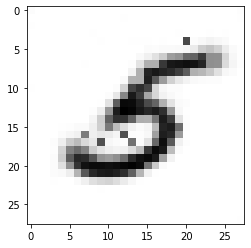

madry_adv_trained_6_schott_VAE_8
tensor([[0.0726, 0.0833, 0.0764, 0.0732, 0.0600, 0.0713, 0.0644, 0.0711, 1.2210,
         0.0809]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.9290994 0.       ]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
tensor([0.1355], device='cuda:0')
tensor([0.9291], device='cuda:0')


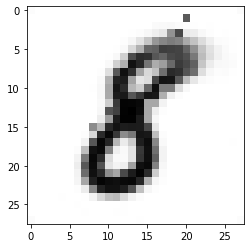

madry_adv_trained_6_small_VGG_0
tensor([[0.3079, 0.3024, 0.2631, 0.2018, 0.1491, 0.1305, 0.1885, 0.1277, 0.7089,
         0.1290]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.3086], device='cuda:0')
tensor([0.], device='cuda:0')


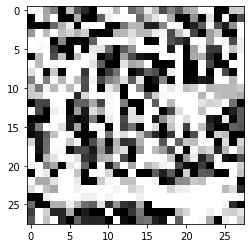

madry_adv_trained_6_small_VGG_4
tensor([[0.0962, 0.0984, 1.0308, 0.1413, 0.1036, 0.0928, 0.1420, 0.0910, 0.1460,
         0.0889]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.1777], device='cuda:0')
tensor([0.], device='cuda:0')


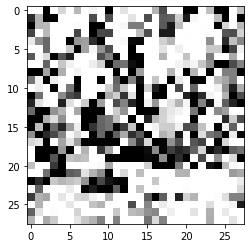

madry_adv_trained_6_small_VGG_negative_0
tensor([[0.2793, 0.4047, 0.2553, 0.1900, 0.0942, 0.2705, 0.1214, 0.1556, 0.8653,
         0.1280]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.4023], device='cuda:0')
tensor([0.], device='cuda:0')


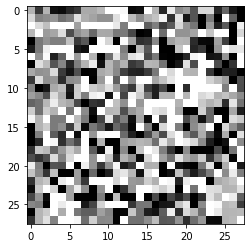

madry_adv_trained_6_small_VGG_negative_5
tensor([[0.2306, 0.3529, 0.2286, 0.2017, 0.1229, 0.2032, 0.1647, 0.1237, 0.9292,
         0.1315]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.2710], device='cuda:0')
tensor([0.], device='cuda:0')


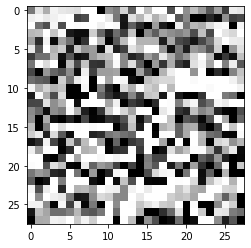

madry_adv_trained_7_madry_l2_0
tensor([[0.2480, 0.1902, 1.3242, 0.1891, 0.1474, 0.1802, 0.1873, 0.1133, 0.0905,
         0.1523]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.9362], device='cuda:0')
tensor([0.], device='cuda:0')


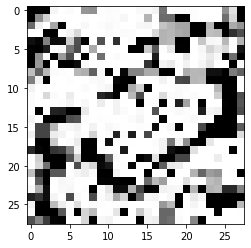

madry_adv_trained_7_madry_l2_8
tensor([[0.1411, 0.1963, 0.2362, 0.1801, 0.1182, 0.1937, 0.1392, 0.2122, 1.3818,
         0.1497]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.5631], device='cuda:0')
tensor([0.], device='cuda:0')


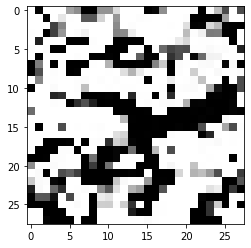

madry_adv_trained_7_schott_VAE_4
tensor([[0.0701, 0.0765, 0.0612, 0.0674, 1.4710, 0.0799, 0.0778, 0.0606, 0.0693,
         0.0842]], device='cuda:0')
[0.        0.        0.        0.        0.9562969 0.        0.
 0.        0.        0.       ]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
tensor([0.1219], device='cuda:0')
tensor([0.9563], device='cuda:0')


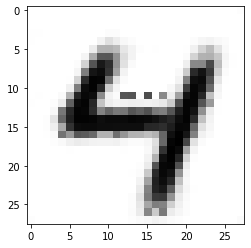

madry_adv_trained_7_schott_VAE_9
tensor([[0.0644, 0.0801, 0.0556, 0.0885, 0.0703, 0.0716, 0.0782, 0.0786, 0.0691,
         1.2741]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.9686351]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
tensor([0.1157], device='cuda:0')
tensor([0.9686], device='cuda:0')


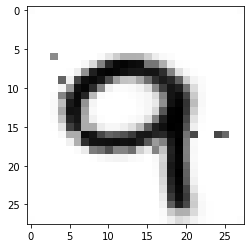

madry_adv_trained_7_small_VGG_5
tensor([[0.2503, 0.4360, 0.2344, 0.6197, 0.1082, 0.2326, 0.1631, 0.2083, 0.1875,
         0.1860]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.4136], device='cuda:0')
tensor([0.], device='cuda:0')


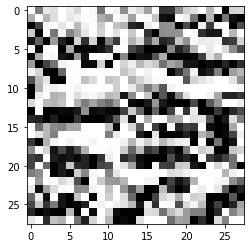

madry_adv_trained_7_small_VGG_6
tensor([[0.3471, 0.3943, 0.2261, 0.3277, 0.2608, 0.2621, 0.6758, 0.1768, 0.2417,
         0.2251]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.5720], device='cuda:0')
tensor([0.], device='cuda:0')


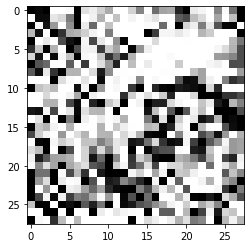

madry_adv_trained_7_small_VGG_negative_2
tensor([[0.2712, 0.2783, 0.1616, 0.2240, 0.1293, 0.1766, 0.1564, 0.0945, 0.9776,
         0.1302]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.1324], device='cuda:0')
tensor([0.], device='cuda:0')


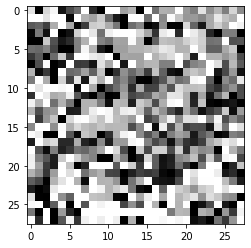

madry_adv_trained_7_small_VGG_negative_4
tensor([[0.1603, 0.3861, 0.2807, 0.2055, 0.1017, 0.2462, 0.0980, 0.2350, 0.9974,
         0.1651]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.3944], device='cuda:0')
tensor([0.], device='cuda:0')


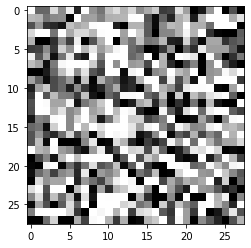

madry_adv_trained_8_madry_l2_5
tensor([[0.1636, 0.1671, 0.0960, 0.1508, 0.1119, 1.4017, 0.0994, 0.1504, 0.1284,
         0.1117]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.3076], device='cuda:0')
tensor([0.], device='cuda:0')


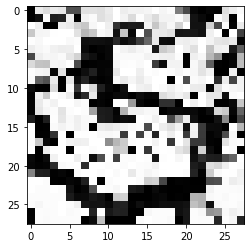

madry_adv_trained_8_madry_l2_7
tensor([[0.1702, 0.3584, 0.4222, 0.3293, 0.1351, 0.2366, 0.1344, 0.4030, 0.4905,
         0.2338]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.2186], device='cuda:0')
tensor([0.], device='cuda:0')


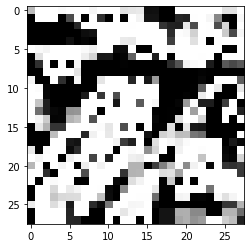

madry_adv_trained_8_schott_VAE_4
tensor([[0.0657, 0.0846, 0.0671, 0.0527, 1.2629, 0.0661, 0.0643, 0.0665, 0.0653,
         0.0727]], device='cuda:0')
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
tensor([0.0984], device='cuda:0')
tensor([1.], device='cuda:0')


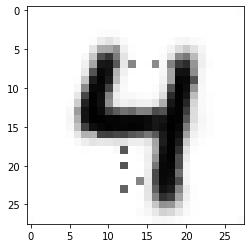

madry_adv_trained_8_schott_VAE_5
tensor([[0.0606, 0.0627, 0.0458, 0.0543, 0.0531, 1.1187, 0.0562, 0.0565, 0.0587,
         0.0461]], device='cuda:0')
[0.         0.         0.         0.         0.         0.92320305
 0.         0.         0.         0.        ]
[0.  0.  0.  0.  0.  0.5 0.  0.  0.5 0. ]
tensor([0.1384], device='cuda:0')
tensor([0.9232], device='cuda:0')


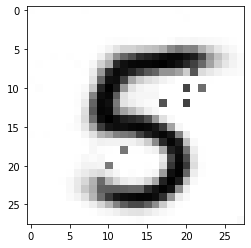

madry_adv_trained_8_small_VGG_5
tensor([[0.1262, 0.2294, 0.4786, 0.1951, 0.0755, 0.1400, 0.1073, 0.1889, 0.4394,
         0.1028]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.9514], device='cuda:0')
tensor([0.], device='cuda:0')


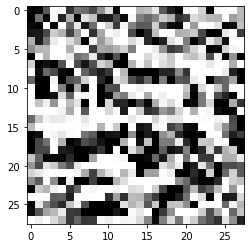

madry_adv_trained_8_small_VGG_7
tensor([[0.0734, 0.0896, 1.3031, 0.0863, 0.0690, 0.0704, 0.1088, 0.0976, 0.0740,
         0.0925]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.9775], device='cuda:0')
tensor([0.], device='cuda:0')


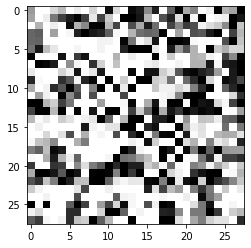

madry_adv_trained_8_small_VGG_negative_1
tensor([[0.1171, 0.3210, 0.6918, 0.2349, 0.1136, 0.1755, 0.1176, 0.2759, 0.7815,
         0.2041]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.3878], device='cuda:0')
tensor([0.], device='cuda:0')


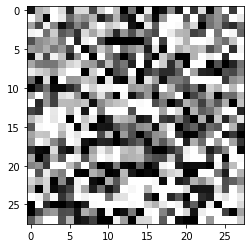

madry_adv_trained_8_small_VGG_negative_9
tensor([[0.2259, 0.4003, 0.2331, 0.3153, 0.1015, 0.1708, 0.1157, 0.1760, 0.7193,
         0.1919]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.3225], device='cuda:0')
tensor([0.], device='cuda:0')


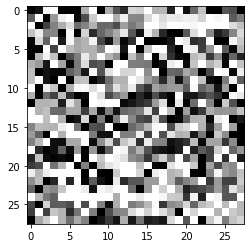

madry_adv_trained_9_madry_l2_1
tensor([[0.2016, 0.2592, 0.1548, 0.5446, 0.1287, 0.2391, 0.1291, 0.2834, 0.1898,
         0.1573]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.25 0.   0.   0.25 0.   0.   0.  ]
tensor([4.0652], device='cuda:0')
tensor([0.], device='cuda:0')


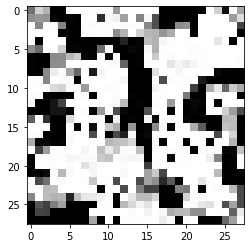

madry_adv_trained_9_madry_l2_4
tensor([[0.1512, 0.1594, 0.1337, 0.1834, 1.2047, 0.1444, 0.1102, 0.1245, 0.2084,
         0.1328]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([2.6073], device='cuda:0')
tensor([0.], device='cuda:0')


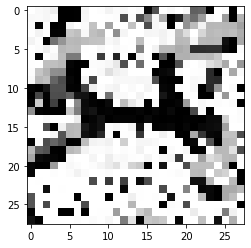

madry_adv_trained_9_schott_VAE_0
tensor([[1.1915, 0.0866, 0.0676, 0.0549, 0.0692, 0.0790, 0.0661, 0.0679, 0.0712,
         0.0786]], device='cuda:0')
[0.91318166 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.1434], device='cuda:0')
tensor([0.9132], device='cuda:0')


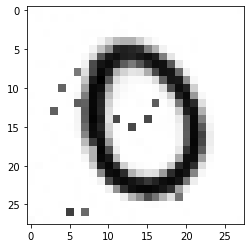

madry_adv_trained_9_schott_VAE_2
tensor([[0.0856, 0.0823, 1.0899, 0.0806, 0.0796, 0.0842, 0.0761, 0.0936, 0.0709,
         0.0767]], device='cuda:0')
[0.        0.        0.7815083 0.        0.        0.        0.
 0.        0.        0.       ]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.2092], device='cuda:0')
tensor([0.7815], device='cuda:0')


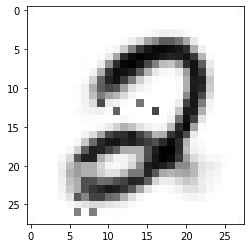

madry_adv_trained_9_small_VGG_1
tensor([[0.0930, 0.1569, 0.2248, 0.2832, 0.1622, 0.4044, 0.1151, 0.0886, 0.0842,
         0.1156]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.  ]
tensor([4.0791], device='cuda:0')
tensor([0.], device='cuda:0')


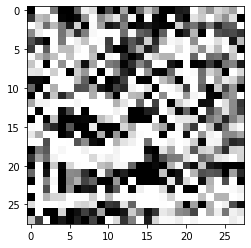

madry_adv_trained_9_small_VGG_2
tensor([[0.1022, 0.1840, 1.2031, 0.1616, 0.1032, 0.1419, 0.0684, 0.1690, 0.2492,
         0.1308]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.6815], device='cuda:0')
tensor([0.], device='cuda:0')


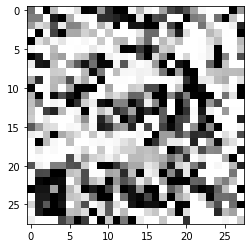

madry_adv_trained_9_small_VGG_negative_0
tensor([[0.1452, 0.3727, 0.3467, 0.9320, 0.1022, 0.2025, 0.0843, 0.2196, 0.2138,
         0.2087]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.1699], device='cuda:0')
tensor([0.], device='cuda:0')


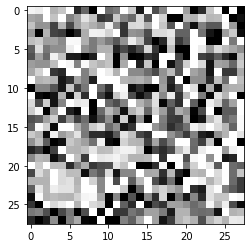

madry_adv_trained_9_small_VGG_negative_1
tensor([[0.1576, 0.3436, 0.1717, 0.8441, 0.1023, 0.1596, 0.1004, 0.2042, 0.1388,
         0.1577]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.4956], device='cuda:0')
tensor([0.], device='cuda:0')


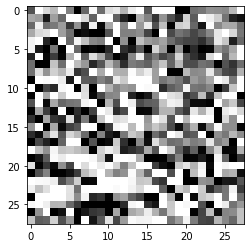

madry_l2_0_schott_VAE_5
tensor([[0.0990, 0.0816, 0.0873, 0.0825, 0.0993, 0.9932, 0.0931, 0.0843, 0.0871,
         0.0953]], device='cuda:0')
[0.        0.        0.        0.        0.        0.9399485 0.
 0.        0.        0.       ]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
tensor([0.1235], device='cuda:0')
tensor([0.9530], device='cuda:0')


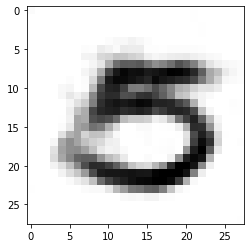

madry_l2_0_schott_VAE_9
tensor([[0.9119, 0.0772, 0.0845, 0.0727, 0.0899, 0.0907, 0.0796, 0.1001, 0.1020,
         0.2574]], device='cuda:0')
[0.6468928 0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
tensor([0.2073], device='cuda:0')
tensor([0.7853], device='cuda:0')


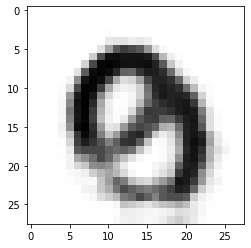

madry_l2_0_small_VGG_4
tensor([[0.2181, 0.1510, 1.0729, 0.1871, 0.2128, 0.1170, 0.1071, 0.1386, 0.1275,
         0.1336]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.2980], device='cuda:0')
tensor([0.], device='cuda:0')


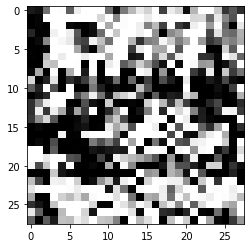

madry_l2_0_small_VGG_6
tensor([[0.2936, 0.4063, 0.5263, 0.1729, 0.0911, 0.1477, 0.1062, 0.1664, 0.3932,
         0.1514]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.5870], device='cuda:0')
tensor([0.], device='cuda:0')


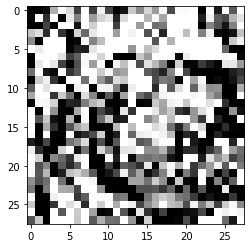

madry_l2_0_small_VGG_negative_4
tensor([[0.3138, 0.5147, 0.2463, 0.3384, 0.1516, 0.3072, 0.1726, 0.2048, 0.3796,
         0.2212]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.2086], device='cuda:0')
tensor([0.], device='cuda:0')


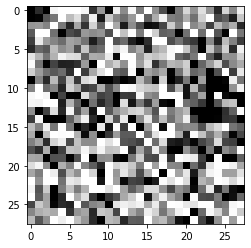

madry_l2_0_small_VGG_negative_6
tensor([[0.3968, 0.4892, 0.4699, 0.2411, 0.0942, 0.3790, 0.1136, 0.2631, 0.4269,
         0.1954]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([5.0014], device='cuda:0')
tensor([0.], device='cuda:0')


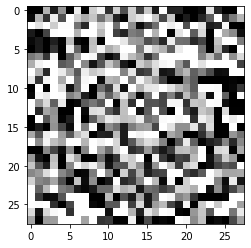

madry_l2_1_schott_VAE_7
tensor([[0.0885, 0.0918, 0.1038, 0.0924, 0.0840, 0.0755, 0.0633, 1.2981, 0.0765,
         0.0729]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0.   0.25 0.   0.   0.   0.   0.   0.75 0.   0.  ]
tensor([0.0954], device='cuda:0')
tensor([1.], device='cuda:0')


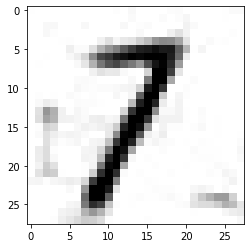

madry_l2_1_schott_VAE_8
tensor([[0.0887, 0.1242, 0.1039, 0.0712, 0.0825, 0.0684, 0.0963, 0.1027, 1.1380,
         0.0833]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.8466101 0.       ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.1767], device='cuda:0')
tensor([0.8466], device='cuda:0')


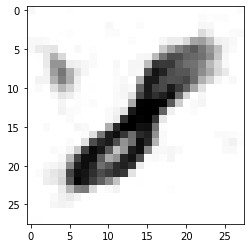

madry_l2_1_small_VGG_4
tensor([[0.1215, 0.2205, 0.2861, 0.1960, 1.0321, 0.1411, 0.1633, 0.1908, 0.1473,
         0.2281]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.2699], device='cuda:0')
tensor([0.], device='cuda:0')


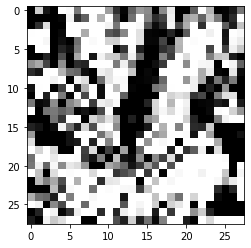

madry_l2_1_small_VGG_8
tensor([[0.2200, 0.3811, 0.3878, 0.4144, 0.1779, 0.2531, 0.1731, 0.4065, 0.7675,
         0.2786]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.9300], device='cuda:0')
tensor([0.], device='cuda:0')


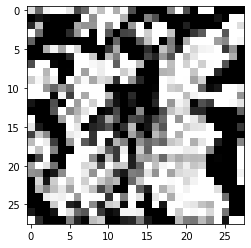

madry_l2_1_small_VGG_negative_2
tensor([[0.1028, 0.2187, 0.5277, 0.2670, 0.0783, 0.1073, 0.0599, 0.1219, 0.2379,
         0.0886]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.9336], device='cuda:0')
tensor([0.], device='cuda:0')


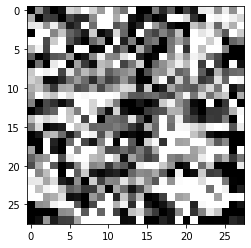

madry_l2_1_small_VGG_negative_7
tensor([[0.1018, 0.2650, 0.2696, 0.3669, 0.1843, 0.1484, 0.0752, 0.5943, 0.3296,
         0.1831]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.4292], device='cuda:0')
tensor([0.], device='cuda:0')


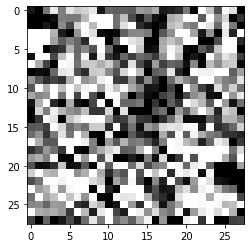

madry_l2_2_schott_VAE_0
tensor([[1.2931, 0.0880, 0.1198, 0.1046, 0.1138, 0.1006, 0.1106, 0.1222, 0.0995,
         0.1114]], device='cuda:0')
[0.6903833 0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.2548], device='cuda:0')
tensor([0.6904], device='cuda:0')


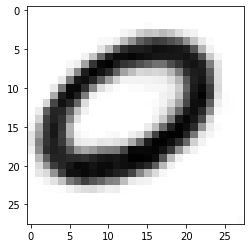

madry_l2_2_schott_VAE_3
tensor([[0.0823, 0.0749, 0.1004, 1.2114, 0.1188, 0.0959, 0.0843, 0.0924, 0.0774,
         0.0759]], device='cuda:0')
[0.        0.        0.        0.9407442 0.        0.        0.
 0.        0.        0.       ]
[0.   0.   0.25 0.75 0.   0.   0.   0.   0.   0.  ]
tensor([0.1296], device='cuda:0')
tensor([0.9407], device='cuda:0')


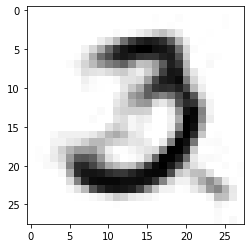

madry_l2_2_small_VGG_0
tensor([[0.1676, 0.1776, 1.6548, 0.1843, 0.0970, 0.1304, 0.0823, 0.1160, 0.1819,
         0.1039]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([5.2291], device='cuda:0')
tensor([0.], device='cuda:0')


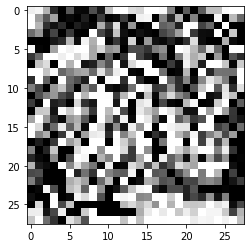

madry_l2_2_small_VGG_5
tensor([[0.2314, 0.2633, 1.1800, 0.2604, 0.1448, 0.2236, 0.2178, 0.1283, 0.2132,
         0.1593]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([5.0855], device='cuda:0')
tensor([0.], device='cuda:0')


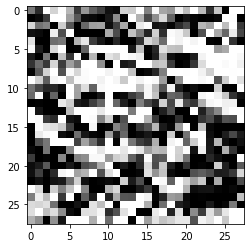

madry_l2_2_small_VGG_negative_0
tensor([[0.2772, 0.4379, 0.7110, 0.2349, 0.1292, 0.2076, 0.1173, 0.1815, 0.4073,
         0.1360]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.7944], device='cuda:0')
tensor([0.], device='cuda:0')


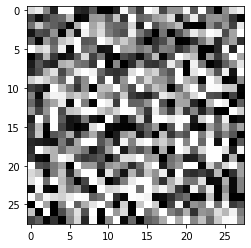

madry_l2_2_small_VGG_negative_9
tensor([[0.0871, 0.1350, 1.2481, 0.1341, 0.0765, 0.0915, 0.0587, 0.1432, 0.2025,
         0.0931]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.9285], device='cuda:0')
tensor([0.], device='cuda:0')


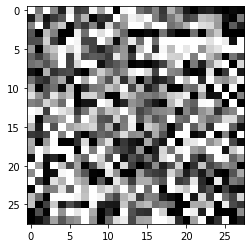

madry_l2_3_schott_VAE_2
tensor([[0.0884, 0.1317, 0.5868, 0.1819, 0.1043, 0.1007, 0.0995, 0.1121, 0.4283,
         0.0842]], device='cuda:0')
[0.       0.       0.153613 0.       0.       0.       0.       0.
 0.       0.      ]
[0.  0.  0.5 0.  0.  0.  0.  0.  0.5 0. ]
tensor([0.1575], device='cuda:0')
tensor([0.8851], device='cuda:0')


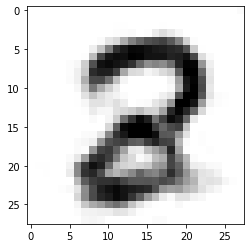

madry_l2_3_schott_VAE_9
tensor([[0.0830, 0.0957, 0.0792, 0.1252, 0.0787, 0.0854, 0.0872, 0.0854, 0.1142,
         1.0916]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.75]
tensor([0.0857], device='cuda:0')
tensor([1.], device='cuda:0')


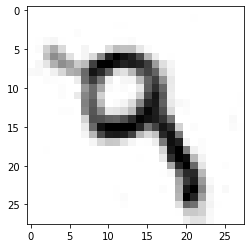

madry_l2_3_small_VGG_1
tensor([[0.1235, 0.2947, 0.3843, 1.1950, 0.0934, 0.1493, 0.0797, 0.2185, 0.1389,
         0.1705]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.  ]
tensor([4.6925], device='cuda:0')
tensor([0.], device='cuda:0')


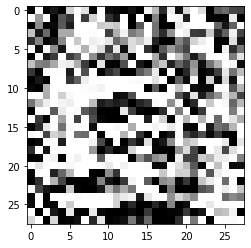

madry_l2_3_small_VGG_9
tensor([[0.1203, 0.2373, 0.1909, 1.2005, 0.1131, 0.1582, 0.1102, 0.2433, 0.1409,
         0.1539]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.0285], device='cuda:0')
tensor([0.], device='cuda:0')


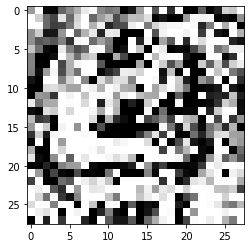

madry_l2_3_small_VGG_negative_1
tensor([[0.1869, 0.4085, 0.2448, 1.1828, 0.1014, 0.1651, 0.1179, 0.1720, 0.2014,
         0.1995]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.1719], device='cuda:0')
tensor([0.], device='cuda:0')


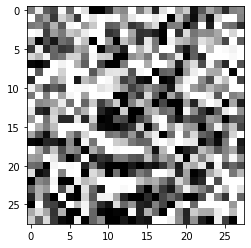

madry_l2_3_small_VGG_negative_6
tensor([[0.1190, 0.1787, 0.0882, 1.0264, 0.0864, 0.1432, 0.0968, 0.0767, 0.0744,
         0.0861]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.1814], device='cuda:0')
tensor([0.], device='cuda:0')


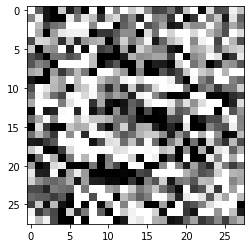

madry_l2_4_schott_VAE_1
tensor([[0.0897, 1.0821, 0.1423, 0.0893, 0.1342, 0.1309, 0.0809, 0.1126, 0.0803,
         0.1282]], device='cuda:0')
[0.         0.85579705 0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.   0.25 0.   0.   0.75 0.   0.   0.   0.   0.  ]
tensor([0.1721], device='cuda:0')
tensor([0.8558], device='cuda:0')


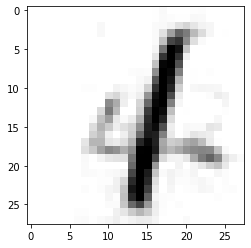

madry_l2_4_schott_VAE_7
tensor([[0.0847, 0.0729, 0.0866, 0.0760, 0.0960, 0.0691, 0.1060, 1.0091, 0.0576,
         0.1016]], device='cuda:0')
[0.         0.         0.         0.         0.         0.
 0.         0.94778085 0.         0.        ]
[0.   0.   0.   0.   0.75 0.   0.   0.   0.   0.  ]
tensor([0.1261], device='cuda:0')
tensor([0.9478], device='cuda:0')


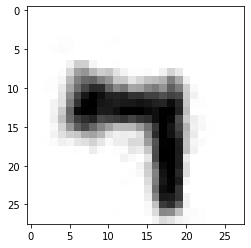

madry_l2_4_small_VGG_1
tensor([[0.2156, 0.4753, 0.4051, 0.2474, 0.1392, 0.2158, 0.0904, 0.2190, 0.6107,
         0.1842]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.4821], device='cuda:0')
tensor([0.], device='cuda:0')


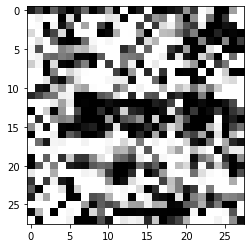

madry_l2_4_small_VGG_2
tensor([[0.0755, 0.1889, 0.1560, 0.1924, 0.2766, 0.1282, 0.0805, 0.1610, 0.6147,
         0.0719]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.0062], device='cuda:0')
tensor([0.], device='cuda:0')


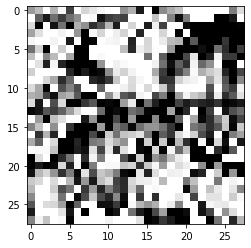

madry_l2_4_small_VGG_negative_5
tensor([[0.2207, 0.4326, 0.2382, 0.2460, 0.1153, 0.1987, 0.1480, 0.1809, 1.0533,
         0.1516]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.1542], device='cuda:0')
tensor([0.], device='cuda:0')


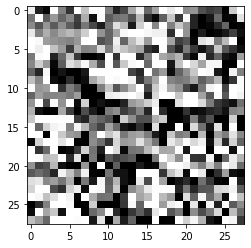

madry_l2_4_small_VGG_negative_8
tensor([[0.0944, 0.2518, 0.1573, 0.2063, 0.3928, 0.1932, 0.1015, 0.3362, 0.1945,
         0.0963]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.1840], device='cuda:0')
tensor([0.], device='cuda:0')


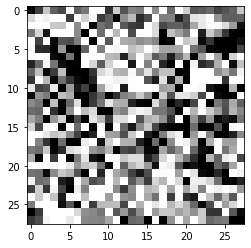

madry_l2_5_schott_VAE_4
tensor([[0.0788, 0.0992, 0.0639, 0.0788, 0.9081, 0.2226, 0.0711, 0.0917, 0.0766,
         0.0715]], device='cuda:0')
[0.        0.        0.        0.        0.8162352 0.        0.
 0.        0.        0.       ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
tensor([0.0980], device='cuda:0')
tensor([1.], device='cuda:0')


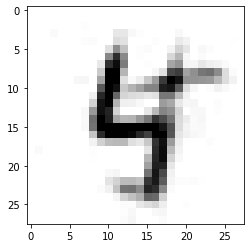

madry_l2_5_schott_VAE_6
tensor([[0.0887, 0.1212, 0.0771, 0.1011, 0.0656, 0.1396, 1.1814, 0.0836, 0.0818,
         0.0825]], device='cuda:0')
[0.         0.         0.         0.         0.         0.
 0.84813255 0.         0.         0.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
tensor([0.1759], device='cuda:0')
tensor([0.8481], device='cuda:0')


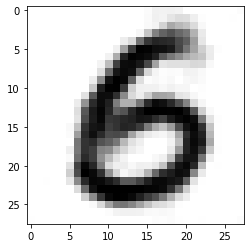

madry_l2_5_small_VGG_0
tensor([[0.1371, 0.1961, 0.1012, 0.1731, 0.0782, 1.1808, 0.0901, 0.1230, 0.1457,
         0.1066]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.7475], device='cuda:0')
tensor([0.], device='cuda:0')


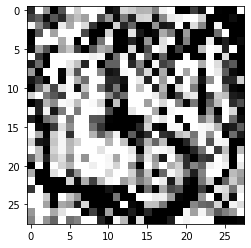

madry_l2_5_small_VGG_3
tensor([[0.2414, 0.4157, 0.2174, 0.4135, 0.1033, 0.4268, 0.1759, 0.1367, 0.1941,
         0.1758]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([5.1195], device='cuda:0')
tensor([0.], device='cuda:0')


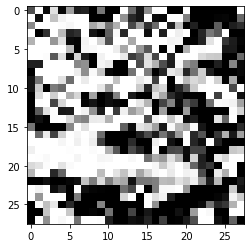

madry_l2_5_small_VGG_negative_0
tensor([[0.2179, 0.3994, 0.2672, 0.2765, 0.1059, 0.9939, 0.1356, 0.1961, 0.1708,
         0.1806]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.6891], device='cuda:0')
tensor([0.], device='cuda:0')


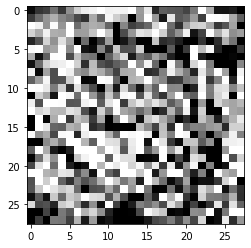

madry_l2_5_small_VGG_negative_9
tensor([[0.2520, 0.5044, 0.2205, 0.5084, 0.1494, 0.3429, 0.1882, 0.2547, 0.2913,
         0.2126]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.3300], device='cuda:0')
tensor([0.], device='cuda:0')


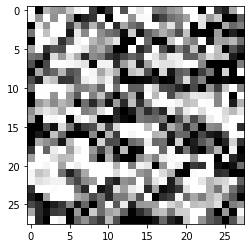

madry_l2_6_schott_VAE_5
tensor([[0.0838, 0.0926, 0.0538, 0.0904, 0.0903, 1.0096, 0.0939, 0.0956, 0.0811,
         0.0880]], device='cuda:0')
[0.        0.        0.        0.        0.        0.9786215 0.
 0.        0.        0.       ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
tensor([0.1107], device='cuda:0')
tensor([0.9786], device='cuda:0')


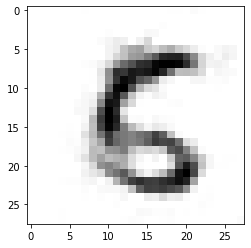

madry_l2_6_schott_VAE_8
tensor([[0.0583, 0.0846, 0.0589, 0.0954, 0.0845, 0.0697, 0.1345, 0.0990, 0.9546,
         0.0826]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.9091848 0.       ]
[0.   0.   0.   0.   0.   0.   0.75 0.   0.25 0.  ]
tensor([0.0934], device='cuda:0')
tensor([1.], device='cuda:0')


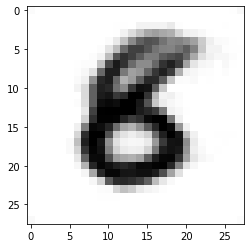

madry_l2_6_small_VGG_3
tensor([[0.4117, 0.2839, 0.5701, 0.3160, 0.2137, 0.2563, 0.3147, 0.2045, 0.1881,
         0.1597]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.6133], device='cuda:0')
tensor([0.], device='cuda:0')


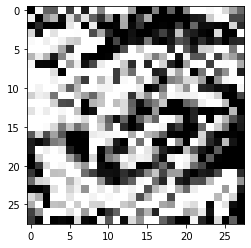

madry_l2_6_small_VGG_5
tensor([[0.3488, 0.2733, 0.3234, 0.4165, 0.1962, 0.2158, 0.3912, 0.1690, 0.2732,
         0.1947]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.5080], device='cuda:0')
tensor([0.], device='cuda:0')


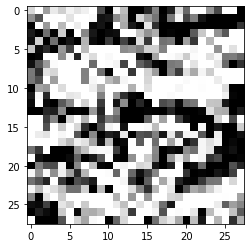

madry_l2_6_small_VGG_negative_2
tensor([[0.1337, 0.3477, 0.1831, 0.2013, 0.0934, 0.1781, 0.1556, 0.1641, 0.9398,
         0.1205]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.6295], device='cuda:0')
tensor([0.], device='cuda:0')


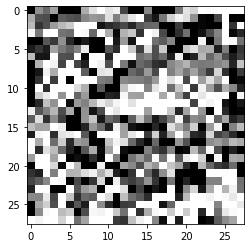

madry_l2_6_small_VGG_negative_3
tensor([[0.2862, 0.2265, 0.8129, 0.1834, 0.1783, 0.1785, 0.2331, 0.1769, 0.2327,
         0.1296]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.3932], device='cuda:0')
tensor([0.], device='cuda:0')


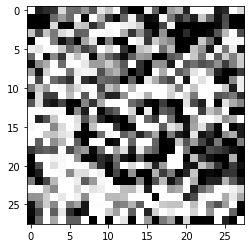

madry_l2_7_schott_VAE_1
tensor([[0.0671, 0.9587, 0.0972, 0.0957, 0.1168, 0.1318, 0.1011, 0.1757, 0.0906,
         0.1104]], device='cuda:0')
[0.        0.8648982 0.        0.        0.        0.        0.
 0.        0.        0.       ]
[0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.  ]
tensor([0.1287], device='cuda:0')
tensor([0.9427], device='cuda:0')


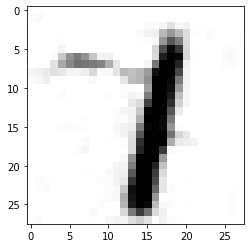

madry_l2_7_schott_VAE_4
tensor([[0.0812, 0.0943, 0.0785, 0.0907, 1.5091, 0.0935, 0.0826, 0.0788, 0.0750,
         0.1005]], device='cuda:0')
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
tensor([0.0942], device='cuda:0')
tensor([1.], device='cuda:0')


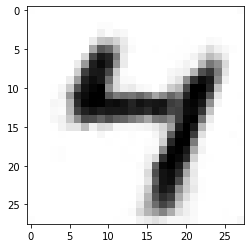

madry_l2_7_small_VGG_8
tensor([[0.1741, 0.4074, 0.2455, 0.2763, 0.1981, 0.3000, 0.2144, 0.7250, 0.2194,
         0.2420]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([3.6110], device='cuda:0')
tensor([0.], device='cuda:0')


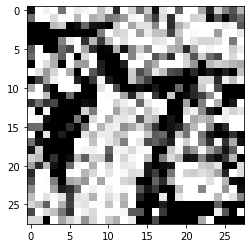

madry_l2_7_small_VGG_9
tensor([[0.1376, 0.2911, 0.2114, 0.2036, 0.1563, 0.2737, 0.1247, 0.6734, 0.2832,
         0.2109]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.3397], device='cuda:0')
tensor([0.], device='cuda:0')


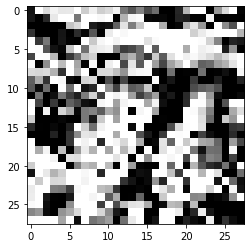

madry_l2_7_small_VGG_negative_3
tensor([[0.1304, 0.4060, 0.6324, 0.2864, 0.1104, 0.2368, 0.0937, 0.3446, 0.6215,
         0.1921]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.8547], device='cuda:0')
tensor([0.], device='cuda:0')


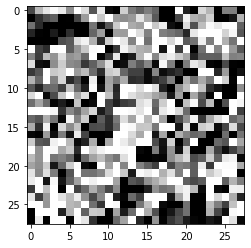

madry_l2_7_small_VGG_negative_8
tensor([[0.0902, 0.1914, 0.7537, 0.1944, 0.1150, 0.1289, 0.0862, 0.2361, 0.1150,
         0.0794]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([4.6093], device='cuda:0')
tensor([0.], device='cuda:0')


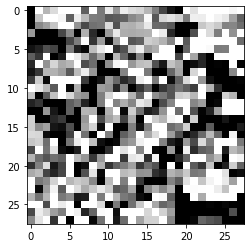

madry_l2_8_schott_VAE_2
tensor([[0.0939, 0.0941, 1.0809, 0.0923, 0.1051, 0.0980, 0.1041, 0.0991, 0.1245,
         0.0906]], device='cuda:0')
[0.        0.        0.7843516 0.        0.        0.        0.
 0.        0.        0.       ]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.2078], device='cuda:0')
tensor([0.7844], device='cuda:0')


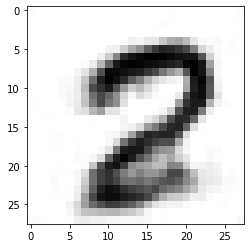

madry_l2_8_schott_VAE_6
tensor([[0.1165, 0.1282, 0.0979, 0.1018, 0.0970, 0.1098, 1.3021, 0.0845, 0.1242,
         0.1014]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.7610721
 0.        0.        0.       ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
tensor([0.2195], device='cuda:0')
tensor([0.7611], device='cuda:0')


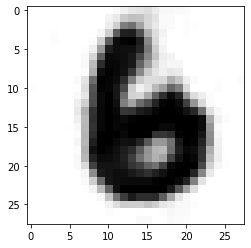

In [13]:
from PIL import Image, ImageOps

img_sm = np.unique(df_sm['image'])

num_images = 20  # len(img_sm)

for i in range(650,750):
    
    img_name = img_sm[i]
    print(img_name)
    
    ind = np.where(img_names == img_name)
    print(outPRED[ind])
    
    print(df_sm[df_sm['image'] == img_name].predictions.to_numpy())
    
    print(df_sm[df_sm['image'] == img_name].rating.to_numpy())
    
    print(L_recon_all[ind])
    print(c_factor[ind])
    
    img_path = img_folder + img_name + '.png'
    img =  (np.array(ImageOps.grayscale(Image.open(img_path))) / 255.0) #  cv2.imread(path, 0)
    plt.imshow(img, cmap = 'gray')
    plt.show()